<h1>Data Analysis</h1>

In [ ]:
import csv
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import scipy.stats as stats
import matplotlib.patches as mpatches
from sklearn.ensemble import RandomForestRegressor
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [850]:
# school files w/ zipcode
SCHOOL_FED = "federal_college_data_final.csv"
SCHOOL_FORBES_ZIP = "forbes_rankings_final.csv"
SCHOOL_RATINGS = "myplan_rankings_final.csv"

# merged files
SCHOOL_ALL = "schools_merged.csv" # list of all schools and their associated values, based on institution name
SCHOOL_COMPLETE = "schools_complete.csv" #list of schools that have all values filled - can be used for modeling
FINAL_CITY_CRIME_ZIPS = "us_cities_crime_zips2.csv" #crime reports with associated zip code -- cross reference school zip and crime rates
TOP_SCHOOLS = 'merged_top_schools.csv' # list of top schools that appear on top 300 schools of both the Forbes and myPlan data
CORRELATIONS_PVALS = "sig_correlations_with_pvals.csv" #all correlation values of variables compared to one another with statistical significance based on p value

In [ ]:
# variables in files
# schools_merged.csv columns - ['Zip Code_1', 'school', 'City_1', 'State_1', 'Locale_1', 'Average Faculty Salary_1', 'Average SAT Score_1', 'Admission Rate_1', '4-Year Completion Rate_1', 'Average Net Price (Public)_1', 'Average Net Price (Private)_1', 'Cost of Attendance (Academic Year)_1', 'Median Debt of Completers_1', 'Median Earnings (8 Years After Entry)_1', 'Mean Earnings (8 Years After Entry)_1', 'rank_2', 'state_2', 'grade_2', 'medianBaseSalary_2', 'studentPopulation_2', 'campusSetting_2', 'schoolSize_2', 'description_2', 'uri_2', 'institutionType_2', 'carnegieClassification_2', 'studentFacultyRatio_2', 'totalGrantAid_2', 'percentOfStudentsFinAid_2', 'percentOfStudentsGrant_2', 'Prestige_3', 'Satisfaction_3', 'Resources & Facilities_3', 'Safety_3', 'Teacher Support_3', 'School Administration_3', 'Campus Setting_3', 'Average Score_3']
# schools_complete.csv columns - ['Zip Code_1', 'school', 'City_1', 'State_1', 'Locale_1', 'Average Faculty Salary_1', 'Average SAT Score_1', 'Admission Rate_1', '4-Year Completion Rate_1', 'Average Net Price (Public)_1', 'Average Net Price (Private)_1', 'Cost of Attendance (Academic Year)_1', 'Median Debt of Completers_1', 'Median Earnings (8 Years After Entry)_1', 'Mean Earnings (8 Years After Entry)_1', 'rank_2', 'state_2', 'grade_2', 'medianBaseSalary_2', 'studentPopulation_2', 'campusSetting_2', 'schoolSize_2', 'description_2', 'uri_2', 'institutionType_2', 'carnegieClassification_2', 'studentFacultyRatio_2', 'totalGrantAid_2', 'percentOfStudentsFinAid_2', 'percentOfStudentsGrant_2', 'Prestige_3', 'Satisfaction_3', 'Resources & Facilities_3', 'Safety_3', 'Teacher Support_3', 'School Administration_3', 'Campus Setting_3', 'Average Score_3']
# us_cities_crime_zips2.csv columns - ['State', 'City', 'Population', 'Violent crime', 'Murder and nonnegligent manslaughter', 'Rape', 'Robbery', 'Aggravated assault', 'Property crime', 'Burglary', 'Larceny- theft', 'Motor vehicle theft', 'Arson1', 'Zip Code', 'Crime Sum', 'Crime Ratio']
# forbes_rankings_final.csv columns - ['rank', 'name', 'zip code', 'state', 'grade', 'medianBaseSalary', 'studentPopulation', 'campusSetting', 'schoolSize', 'description', 'uri', 'institutionType', 'carnegieClassification', 'studentFacultyRatio', 'totalGrantAid', 'percentOfStudentsFinAid', 'percentOfStudentsGrant']
# myplan_rankings.csv columns - ['School', 'zip code', 'Prestige', 'Satisfaction', 'Resources & Facilities', 'Safety', 'Teacher Support', 'School Administration', 'Campus Setting', 'Average Score']
# federal_college_data.csv columns - ['Zip Code', 'School Name', 'City', 'State', 'Locale', 'Average Faculty Salary', 'Average SAT Score', 'Admission Rate', '4-Year Completion Rate', 'Average Net Price (Public)', 'Average Net Price (Private)', 'Cost of Attendance (Academic Year)', 'Median Debt of Completers', 'Median Earnings (8 Years After Entry)', 'Mean Earnings (8 Years After Entry)', 'Type']

<h2>Get Column Names of Files</h2>
This will let us know what variables we are working with

In [892]:
def get_column_names(filename):
    df = pd.read_csv(filename)
    column_list = df.columns.tolist()
    return f"{filename} columns - {column_list}"

print(get_column_names(SCHOOL_ALL))
print(get_column_names(SCHOOL_FORBES_ZIP))
print(get_column_names(SCHOOL_COMPLETE))
print(get_column_names(FINAL_CITY_CRIME_ZIPS))
print(get_column_names(SCHOOL_RATINGS))
print(get_column_names(SCHOOL_FED))

schools_merged.csv columns - ['Zip Code_1', 'school', 'City_1', 'State_1', 'Locale_1', 'Average Faculty Salary_1', 'Average SAT Score_1', 'Admission Rate_1', '4-Year Completion Rate_1', 'Average Net Price (Public)_1', 'Average Net Price (Private)_1', 'Cost of Attendance (Academic Year)_1', 'Median Debt of Completers_1', 'Median Earnings (8 Years After Entry)_1', 'Mean Earnings (8 Years After Entry)_1', 'rank_2', 'state_2', 'grade_2', 'medianBaseSalary_2', 'studentPopulation_2', 'campusSetting_2', 'schoolSize_2', 'description_2', 'uri_2', 'institutionType_2', 'carnegieClassification_2', 'studentFacultyRatio_2', 'totalGrantAid_2', 'percentOfStudentsFinAid_2', 'percentOfStudentsGrant_2', 'Prestige_3', 'Satisfaction_3', 'Resources & Facilities_3', 'Safety_3', 'Teacher Support_3', 'School Administration_3', 'Campus Setting_3', 'Average Score_3']
forbes_rankings_final.csv columns - ['rank', 'name', 'zip code', 'state', 'grade', 'medianBaseSalary', 'studentPopulation', 'campusSetting', 'schoo

<h2>Cost of Attendance and Debt by State</h2>

In [868]:
def cost_by_state(filename):
    schools_df = pd.read_csv(filename)
    
    columns_of_interest = ['State', 'Cost of Attendance (Academic Year)', 'Median Debt of Completers', 'Type']
    schools_filtered = schools_df[columns_of_interest].copy()
    
    # removing rows with missing values and convert to numeric values
    schools_filtered = schools_filtered.dropna(subset=['Cost of Attendance (Academic Year)', 'Median Debt of Completers'])
    
    schools_filtered.loc[:, 'Cost of Attendance (Academic Year)'] = pd.to_numeric(
        schools_filtered['Cost of Attendance (Academic Year)'], errors='coerce')
    
    schools_filtered.loc[:, 'Median Debt of Completers'] = pd.to_numeric(
        schools_filtered['Median Debt of Completers'], errors='coerce')
    
    # group data by State and institutionType and calculate the mean for each group
    grouped_data = schools_filtered.groupby(['State', 'Type']).agg(
        mean_cost_of_attendance=('Cost of Attendance (Academic Year)', 'mean'),
        mean_median_debt=('Median Debt of Completers', 'mean')
    ).reset_index()
    
    # make bar chart
    plt.figure(figsize=(16, 8))
    
    # cost of attendance
    plt.subplot(1, 2, 1)
    sns.barplot(x='State', y='mean_cost_of_attendance', hue='Type', data=grouped_data)
    plt.title('Average Cost of Attendance by State and Institution Type')
    plt.xticks(rotation=90)
    plt.xlabel('State')
    plt.ylabel('Average Cost of Attendance')
    
    # median debt
    plt.subplot(1, 2, 2)
    sns.barplot(x='State', y='mean_median_debt', hue='Type', data=grouped_data)
    plt.title('Average Median Debt by State and Institution Type')
    plt.xticks(rotation=90)
    plt.xlabel('State')
    plt.ylabel('Average Median Debt')
    
    plt.tight_layout()
    plt.show()

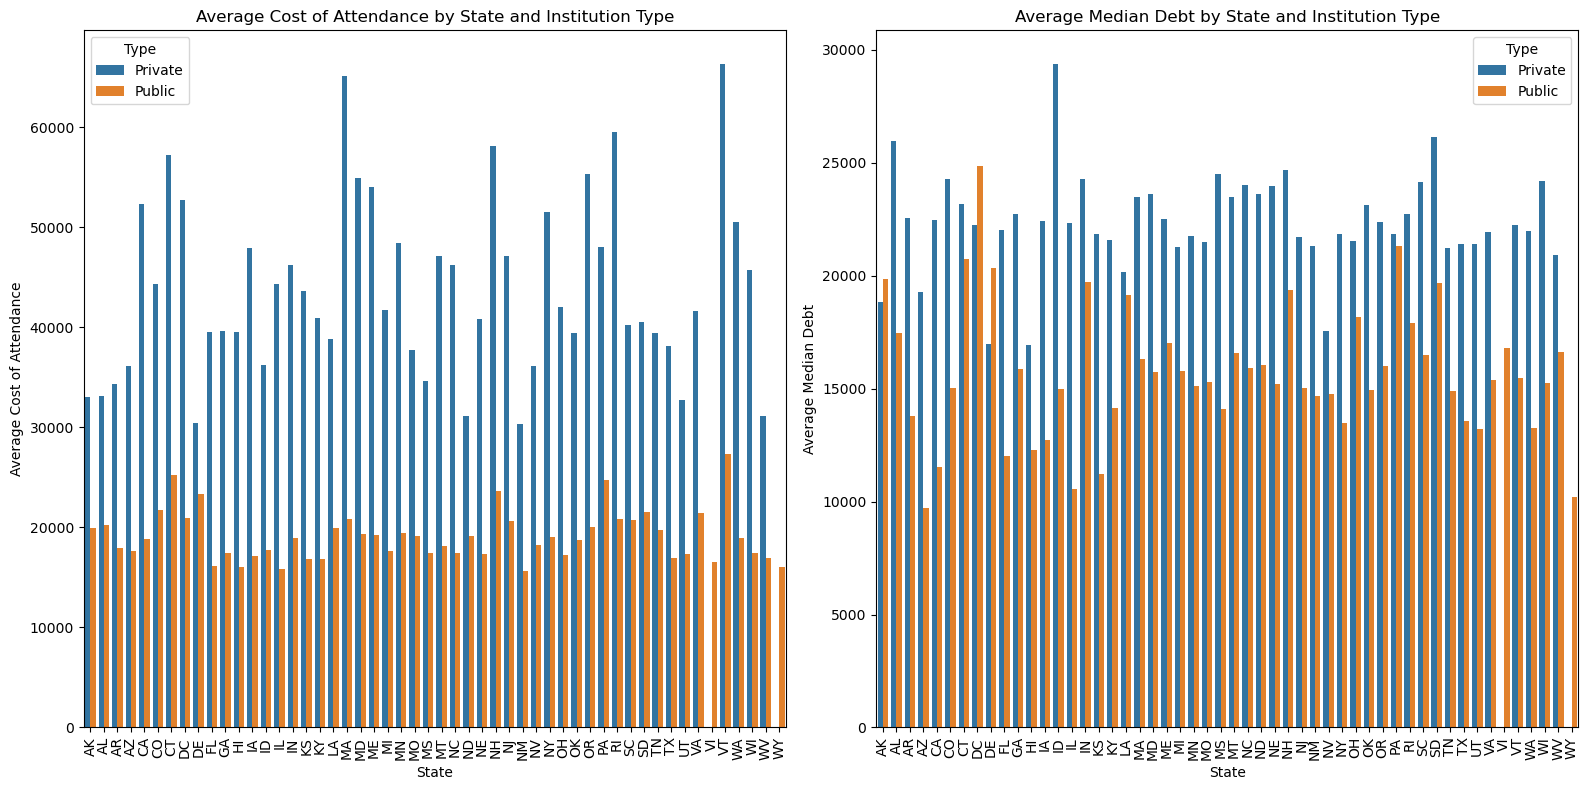

In [870]:
cost_by_state(SCHOOL_FED)

In [856]:
def cost_by_state_type(filename):
    schools_df = pd.read_csv(filename)
    
    columns_of_interest = ['State', 'Cost of Attendance (Academic Year)', 'Median Debt of Completers', 'Type']
    schools_filtered = schools_df[columns_of_interest].copy() 
    
    # removing rows with missing values and convert to numeric values
    schools_filtered.dropna(subset=['Cost of Attendance (Academic Year)', 'Median Debt of Completers'], inplace=True)
    
    schools_filtered['Cost of Attendance (Academic Year)'] = pd.to_numeric(
        schools_filtered['Cost of Attendance (Academic Year)'], errors='coerce')
    
    schools_filtered['Median Debt of Completers'] = pd.to_numeric(
        schools_filtered['Median Debt of Completers'], errors='coerce')
    
    # split data by school type: public and private
    public_schools = schools_filtered[schools_filtered['Type'] == 'Public']
    private_schools = schools_filtered[schools_filtered['Type'] == 'Private']
    
    # group data by state and calculate the mean
    public_grouped_data = public_schools.groupby('State').agg(
        mean_cost_of_attendance=('Cost of Attendance (Academic Year)', 'mean'),
        mean_median_debt=('Median Debt of Completers', 'mean')
    ).reset_index()
    
    private_grouped_data = private_schools.groupby('State').agg(
        mean_cost_of_attendance=('Cost of Attendance (Academic Year)', 'mean'),
        mean_median_debt=('Median Debt of Completers', 'mean')
    ).reset_index()

    # because the values are so different for each type of school, make y axis the same for better side by side comparison
    max_y = max(public_grouped_data[['mean_cost_of_attendance', 'mean_median_debt']].max().max(),
                private_grouped_data[['mean_cost_of_attendance', 'mean_median_debt']].max().max())

    # make bar chart
    plt.figure(figsize=(16, 8))
    
    # public schools
    plt.subplot(1, 2, 1)
    public_melted = pd.melt(public_grouped_data, id_vars=['State'], 
                            value_vars=['mean_cost_of_attendance', 'mean_median_debt'],
                            var_name='Metric', value_name='Value')
    sns.barplot(x='State', y='Value', hue='Metric', data=public_melted)
    plt.title('Public Schools: Cost of Attendance and Median Debt by State')
    plt.xticks(rotation=90)
    plt.xlabel('State')
    plt.ylabel('Amount ($)')
    plt.ylim(0, max_y * 1.1)  # add a small buffer for visual clarity

    # private schools
    plt.subplot(1, 2, 2)
    private_melted = pd.melt(private_grouped_data, id_vars=['State'], 
                             value_vars=['mean_cost_of_attendance', 'mean_median_debt'],
                             var_name='Metric', value_name='Value')
    sns.barplot(x='State', y='Value', hue='Metric', data=private_melted)
    plt.title('Private Schools: Cost of Attendance and Median Debt by State')
    plt.xticks(rotation=90)
    plt.xlabel('State')
    plt.ylabel('Amount ($)')
    plt.ylim(0, max_y * 1.1)

    plt.tight_layout()
    plt.show()

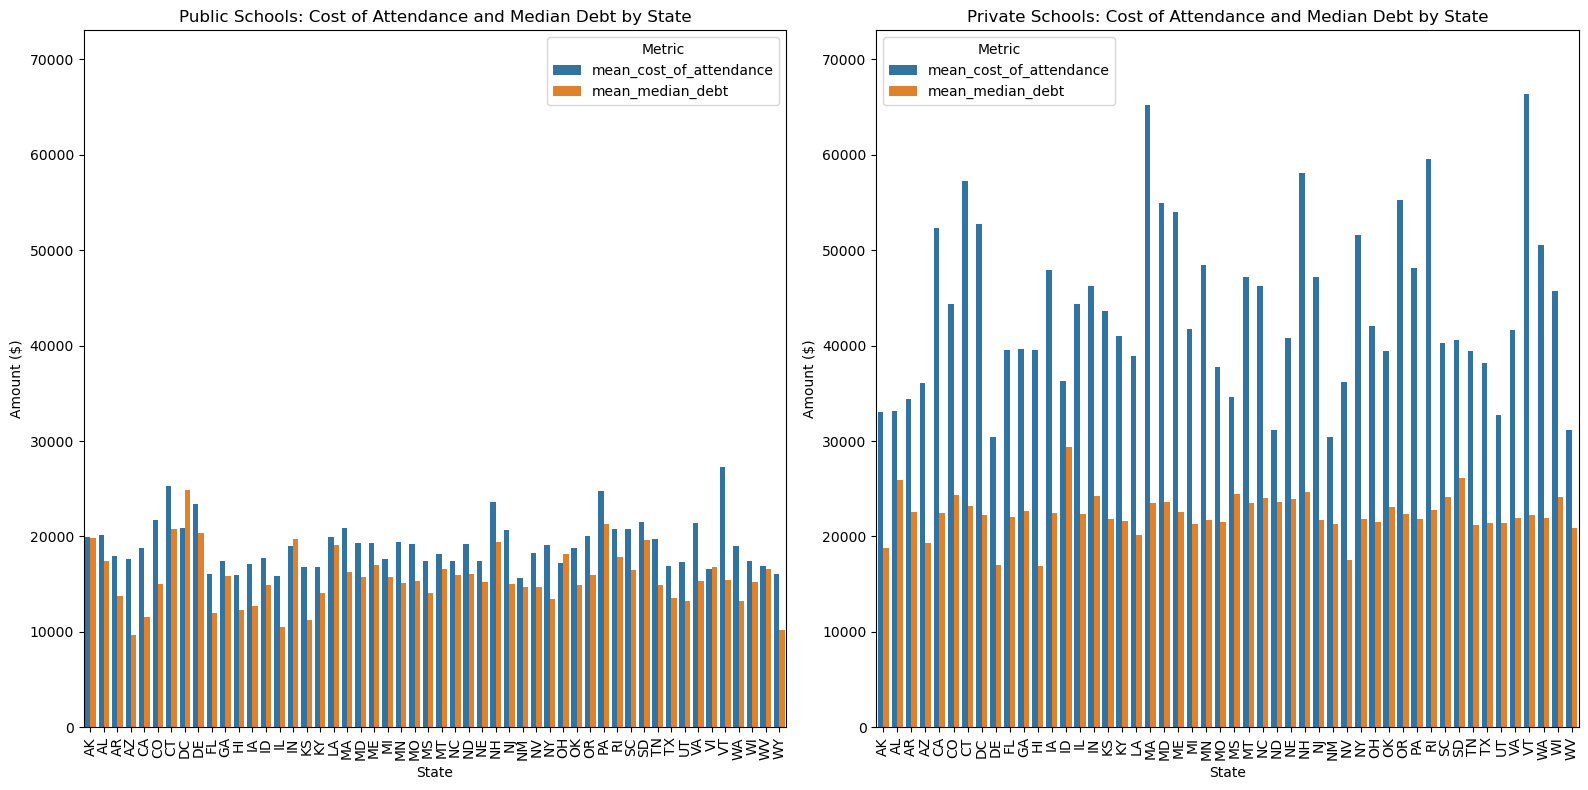

In [858]:
cost_by_state_type(SCHOOL_FED)

In [880]:
def aid_by_institution_type(filename):
    schools_df = pd.read_csv(filename)

    
    columns_of_interest = ['institutionType', 
                           'totalGrantAid', 
                           'percentOfStudentsFinAid', 
                           'percentOfStudentsGrant'
                          ]
    # filter, drop empty data, convert to numeric
    schools_filtered = schools_df[columns_of_interest].copy()
    schools_filtered = schools_filtered.dropna()

    for col in ['totalGrantAid', 'percentOfStudentsFinAid', 'percentOfStudentsGrant']:
        schools_filtered[col] = pd.to_numeric(schools_filtered[col], errors='coerce')

    # normalize vals to convert to percentage scale
    if schools_filtered['percentOfStudentsFinAid'].mean() > 100:
        schools_filtered['percentOfStudentsFinAid'] = schools_filtered['percentOfStudentsFinAid'] / 100
    if schools_filtered['percentOfStudentsGrant'].mean() > 100:
        schools_filtered['percentOfStudentsGrant'] = schools_filtered['percentOfStudentsGrant'] / 100

    # group by school type
    grouped = schools_filtered.groupby('institutionType').agg({
        'totalGrantAid': 'mean',
        'percentOfStudentsFinAid': 'mean',
        'percentOfStudentsGrant': 'mean'
    }).reset_index()

    # multiply percentages to get into 0–100 range
    grouped['percentOfStudentsFinAid'] *= 100
    grouped['percentOfStudentsGrant'] *= 100
    
    # because total aid and percentages are at such massively different scales, make two bar graphs to represent the data
    
    # total Grant Aid plot
    plt.figure(figsize=(10, 5))
    sns.barplot(data=grouped, x='institutionType', y='totalGrantAid', color='#1f77b4')
    plt.title('Average Total Grant Aid by Institution Type')
    plt.xlabel('Institution Type')
    plt.ylabel('Average Total Grant Aid ($)')
    plt.tight_layout()
    plt.show()

    # Percent Receiving Aid/Grants plot
    percent_data = grouped[['institutionType', 'percentOfStudentsFinAid', 'percentOfStudentsGrant']]
    percent_melted = percent_data.melt(id_vars='institutionType', 
                                       var_name='Metric', value_name='Percentage')
    
    # Rename metrics for clarity
    percent_melted['Metric'] = percent_melted['Metric'].map({
        'percentOfStudentsFinAid': '% Receiving Financial Aid',
        'percentOfStudentsGrant': '% Receiving Grants'
    })

    plt.figure(figsize=(10, 5))
    sns.barplot(data=percent_melted, x='institutionType', y='Percentage', hue='Metric')
    plt.title('Percent of Students Receiving Aid or Grants')
    plt.xlabel('Institution Type')
    plt.ylabel('Percentage (%)')
    plt.legend(title='Legend', fontsize='small', title_fontsize='medium')
    plt.tight_layout()
    plt.show()

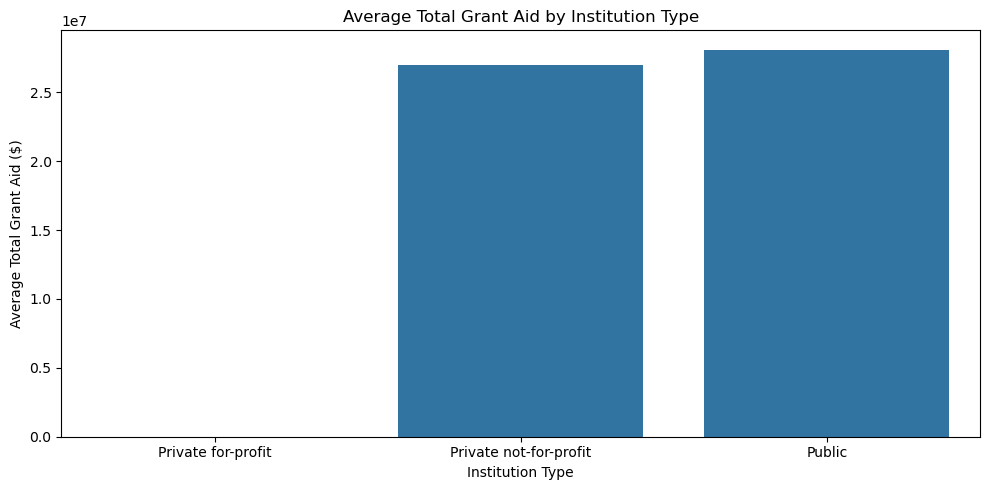

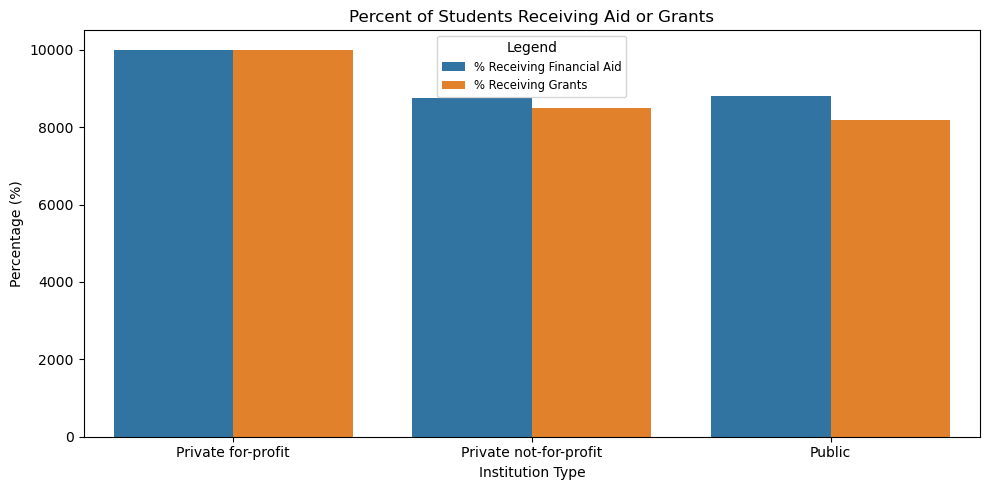

None


In [882]:
print(aid_by_institution_type(SCHOOL_FORBES_ZIP))

<h3>Ranking and Crime Correlation</h3>

In [452]:
def get_crime_ranking_correlations(forbes, crime, merged):

    schools_df = pd.read_csv(merged)
    forbes_rankings_df = pd.read_csv(forbes)
    crime_df = pd.read_csv(crime)

    # Merge school data with Forbes rankings (on Zip Code)
    schools_forbes_df = pd.merge(
        schools_df[['Zip Code_1', 'rank_2', 'Prestige_3']],
        forbes_rankings_df[['zip code', 'rank', 'name']],
        left_on='Zip Code_1', right_on='zip code', how='left'
    )

    # Format zip codes to match
    schools_forbes_df['Zip Code_1'] = schools_forbes_df['Zip Code_1'].astype(str).str.zfill(5)
    crime_df['Zip Code'] = crime_df['Zip Code'].astype(str).str.zfill(5)

    # List of crime-related columns
    crime_variables = [
        'Violent crime', 'Murder and nonnegligent manslaughter', 'Rape', 'Robbery',
        'Aggravated assault', 'Property crime', 'Burglary', 'Larceny- theft',
        'Motor vehicle theft', 'Arson1', 'Crime Sum', 'Crime Ratio'
    ]

    # Merge school+forbes with crime data
    merged_df = pd.merge(
        schools_forbes_df,
        crime_df[['Zip Code'] + crime_variables],
        left_on='Zip Code_1', right_on='Zip Code',
        how='left'
    )

    # Drop rows with missing values in any relevant column
    merged_df.dropna(subset=crime_variables + ['rank_2'], inplace=True)

    # Compute correlation of each crime variable with school ranking
    correlation_results = {}
    for col in crime_variables:
        correlation = merged_df[col].corr(merged_df['rank_2'])
        correlation_results[col] = correlation
        print(f"Correlation between {col} and School Ranking: {correlation}")

    return correlation_results

In [454]:
get_crime_ranking_correlations(SCHOOL_FORBES_ZIP, FINAL_CITY_CRIME_ZIPS, SCHOOL_ALL)

Correlation between Violent crime and School Ranking: -0.0008385192687582373
Correlation between Murder and nonnegligent manslaughter and School Ranking: 0.000152343502501984
Correlation between Rape and School Ranking: -0.00014376998205205597
Correlation between Robbery and School Ranking: -0.0004638036743204565
Correlation between Aggravated assault and School Ranking: -0.0009592012560103209
Correlation between Property crime and School Ranking: -0.00063033481496241
Correlation between Burglary and School Ranking: -0.0009916385250084456
Correlation between Larceny- theft and School Ranking: -0.0005418356842522272
Correlation between Motor vehicle theft and School Ranking: -0.00045854518840094283
Correlation between Arson1 and School Ranking: -0.001004627619403183
Correlation between Crime Sum and School Ranking: -0.0006963190955805609
Correlation between Crime Ratio and School Ranking: -3.231214102522983e-05


{'Violent crime': -0.0008385192687582373,
 'Murder and nonnegligent manslaughter': 0.000152343502501984,
 'Rape': -0.00014376998205205597,
 'Robbery': -0.0004638036743204565,
 'Aggravated assault': -0.0009592012560103209,
 'Property crime': -0.00063033481496241,
 'Burglary': -0.0009916385250084456,
 'Larceny- theft': -0.0005418356842522272,
 'Motor vehicle theft': -0.00045854518840094283,
 'Arson1': -0.001004627619403183,
 'Crime Sum': -0.0006963190955805609,
 'Crime Ratio': -3.231214102522983e-05}

In [ ]:
# analysis

# output
    # Correlation between Violent crime and School Ranking: -0.0008385192687582373
    # Correlation between Murder and nonnegligent manslaughter and School Ranking: 0.000152343502501984
    # Correlation between Rape and School Ranking: -0.00014376998205205597
    # Correlation between Robbery and School Ranking: -0.0004638036743204565
    # Correlation between Aggravated assault and School Ranking: -0.0009592012560103209
    # Correlation between Property crime and School Ranking: -0.00063033481496241
    # Correlation between Burglary and School Ranking: -0.0009916385250084456
    # Correlation between Larceny- theft and School Ranking: -0.0005418356842522272
    # Correlation between Motor vehicle theft and School Ranking: -0.00045854518840094283
    # Correlation between Arson1 and School Ranking: -0.001004627619403183
    # Correlation between Crime Sum and School Ranking: -0.0006963190955805609
    # Correlation between Crime Ratio and School Ranking: -3.231214102522983e-05

# Conclusion: There is no correlation between any specific or aggregated crime rates and school rankings!

In [903]:
def get_all_crime_corr(forbes_data, crime_data, myplan_data):

    crime_df = pd.read_csv(crime_data)
    forbes_df = pd.read_csv(forbes_data)
    myplan_df = pd.read_csv(myplan_data)
    
    # merge Forbes and MyPlan on zip code
    merged_rankings = pd.merge(forbes_df, myplan_df, on='zip code', how='outer')
    
    # merge rankings with crime data on Zip Code
    combined_df = pd.merge(merged_rankings, crime_df, left_on='zip code', right_on='Zip Code', how='left')
    
    numeric_columns = [
        'Violent crime', 'Murder and nonnegligent manslaughter', 'Rape', 'Robbery',
        'Aggravated assault', 'Property crime', 'Burglary', 'Larceny- theft',
        'Motor vehicle theft', 'Arson1', 'Crime Sum', 'Crime Ratio', 'rank',
        'Prestige', 'Satisfaction', 'Resources & Facilities', 'Safety',
        'Teacher Support', 'School Administration', 'Average Score',
        'medianBaseSalary', 'studentPopulation', 'studentFacultyRatio',
        'totalGrantAid', 'percentOfStudentsFinAid', 'percentOfStudentsGrant'
    ]
    
    for col in numeric_columns:
        combined_df[col] = pd.to_numeric(combined_df[col], errors='coerce')

    clean_df = combined_df[numeric_columns].dropna()
    
    # correlation matrix and heatmap
    correlation_matrix = clean_df.corr()
    
    plt.figure(figsize=(18, 14))
    sns.heatmap(correlation_matrix, cmap='coolwarm', annot=False, fmt=".2f")
    plt.title('Correlation Heatmap Between Crime and School Ranking Variables')
    plt.tight_layout()
    plt.show()
    
    display(correlation_matrix.round(4))

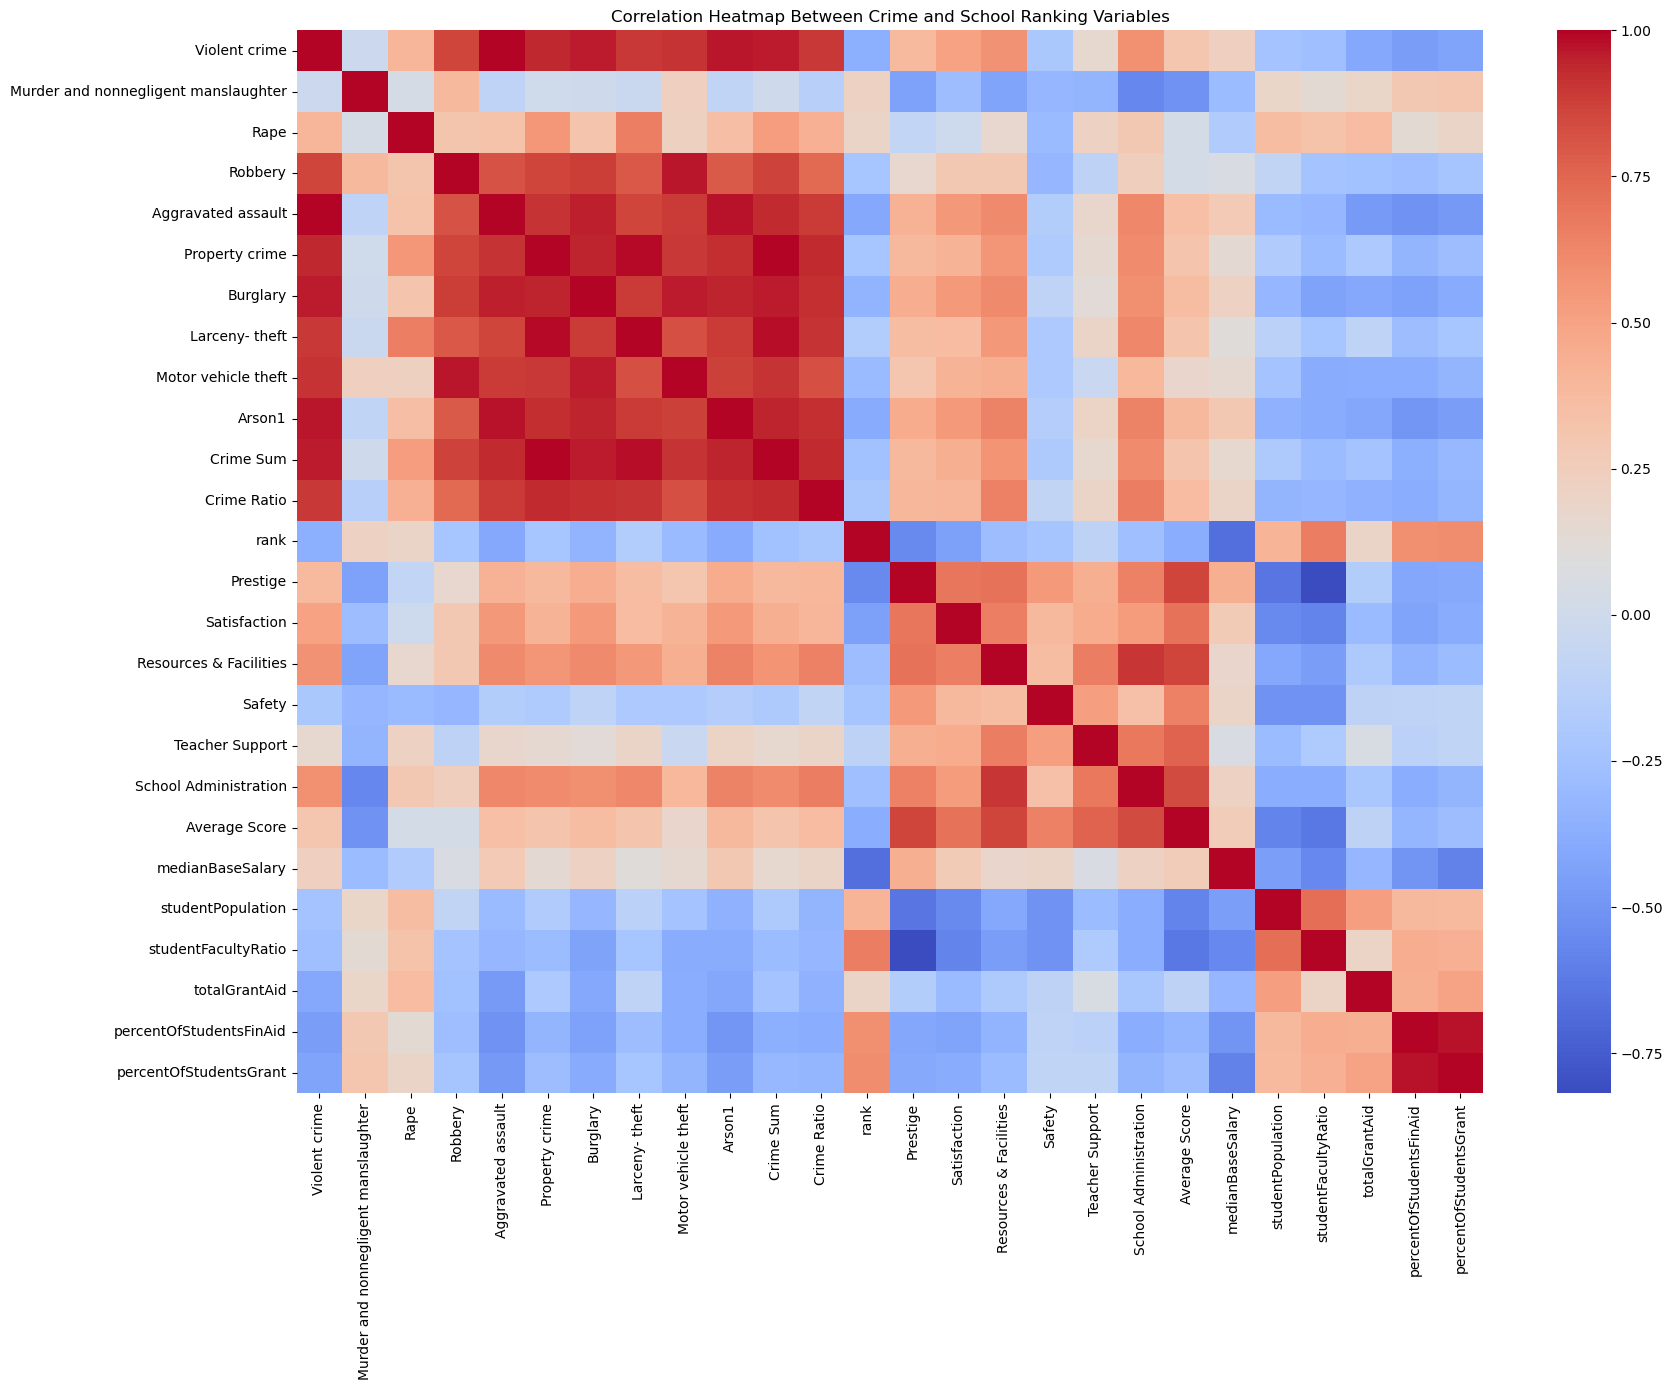

,Violent crime,Murder and nonnegligent manslaughter,Rape,Robbery,Aggravated assault,Property crime,Burglary,Larceny- theft,Motor vehicle theft,Arson1,...,Safety,Teacher Support,School Administration,Average Score,medianBaseSalary,studentPopulation,studentFacultyRatio,totalGrantAid,percentOfStudentsFinAid,percentOfStudentsGrant
Violent crime,1.0000,-0.0285,0.4097,0.8607,0.9934,0.9381,0.9577,0.8966,0.9085,0.9693,...,-0.2056,0.1567,0.5852,0.3040,0.2340,-0.2368,-0.2710,-0.4063,-0.4610,-0.4265
Murder and nonnegligent manslaughter,-0.0285,1.0000,0.0373,0.3850,-0.0993,0.0042,-0.0051,-0.0354,0.2342,-0.0920,...,-0.3162,-0.3339,-0.5663,-0.5121,-0.2859,0.1870,0.1364,0.1833,0.2901,0.3078
Rape,0.4097,0.0373,1.0000,0.3127,0.3287,0.5546,0.3227,0.6524,0.2273,0.3595,...,-0.2950,0.2198,0.2902,0.0239,-0.1765,0.3620,0.3303,0.3723,0.1367,0.1924
Robbery,0.8607,0.3850,0.3127,1.0000,0.8203,0.8606,0.8840,0.7968,0.9670,0.7882,...,-0.3168,-0.1035,0.2446,0.0253,0.0559,-0.0830,-0.2374,-0.2512,-0.2758,-0.2354
Aggravated assault,0.9934,-0.0993,0.3287,0.8203,1.0000,0.9078,0.9504,0.8593,0.8898,0.9734,...,-0.1610,0.1751,0.6170,0.3492,0.2819,-0.2987,-0.3144,-0.4720,-0.5095,-0.4810
Property crime,0.9381,0.0042,0.5546,0.8606,0.9078,1.0000,0.9494,0.9880,0.8983,0.9284,...,-0.1855,0.1537,0.6069,0.3189,0.1408,-0.1753,-0.2921,-0.1966,-0.3336,-0.2789
Burglary,0.9577,-0.0051,0.3227,0.8840,0.9504,0.9494,1.0000,0.8922,0.9576,0.9497,...,-0.0957,0.1214,0.5893,0.3653,0.2216,-0.3166,-0.4301,-0.4009,-0.4396,-0.3918
Larceny- theft,0.8966,-0.0354,0.6524,0.7968,0.8593,0.9880,0.8922,1.0000,0.8240,0.8908,...,-0.1993,0.1907,0.6232,0.3180,0.1102,-0.1172,-0.2249,-0.0998,-0.2823,-0.2258
Motor vehicle theft,0.9085,0.2342,0.2273,0.9670,0.8898,0.8983,0.9576,0.8240,1.0000,0.8776,...,-0.1983,-0.0390,0.3961,0.1777,0.1545,-0.2422,-0.3848,-0.3773,-0.3773,-0.3352
Arson1,0.9693,-0.0920,0.3595,0.7882,0.9734,0.9284,0.9497,0.8908,0.8776,1.0000,...,-0.1540,0.2033,0.6444,0.3822,0.2947,-0.3447,-0.3811,-0.4133,-0.4930,-0.4588


In [905]:
get_all_crime_corr(SCHOOL_FORBES_ZIP, FINAL_CITY_CRIME_ZIPS, SCHOOL_RATINGS)

In [907]:
# analysis

# strong Patterns Within Crime Variables

# Crime and Educational Outcomes
# Higher crime (especially aggravated assault and robbery) correlates negatively with:
# Safety: e.g., -0.2056 with Violent Crime
# Average Score: e.g., -0.3492 with Aggravated Assault
# School Administration support: e.g., -0.6170 with Aggravated Assault
# Prestige & Satisfaction: e.g., -0.4247 and -0.5458 with Aggravated Assault


In [917]:
def get_significant_corr(forbes_data, crime_data, myplan_data, output_file):

    crime_df = pd.read_csv(crime_data)
    forbes_df = pd.read_csv(forbes_data)
    myplan_df = pd.read_csv(myplan_data)

    # Merge Forbes and MyPlan on zip code
    merged_rankings = pd.merge(forbes_df, myplan_df, on='zip code', how='outer')

    # Merge rankings with crime data on Zip Code
    combined_df = pd.merge(merged_rankings, crime_df, left_on='zip code', right_on='Zip Code', how='left')

    numeric_columns = [
        'Violent crime', 'Murder and nonnegligent manslaughter', 'Rape', 'Robbery',
        'Aggravated assault', 'Property crime', 'Burglary', 'Larceny- theft',
        'Motor vehicle theft', 'Arson1', 'Crime Sum', 'Crime Ratio', 'rank',
        'Prestige', 'Satisfaction', 'Resources & Facilities', 'Safety',
        'Teacher Support', 'School Administration', 'Average Score',
        'medianBaseSalary', 'studentPopulation', 'studentFacultyRatio',
        'totalGrantAid', 'percentOfStudentsFinAid', 'percentOfStudentsGrant'
    ]

    # convert to numeric, drop na files, get correlations
    for col in numeric_columns:
        combined_df[col] = pd.to_numeric(combined_df[col], errors='coerce')

    clean_df = combined_df[numeric_columns].dropna()
    correlation_matrix = clean_df.corr()

    # calculate p-values
    def calculate_pvalues(df):
        df_cols = df.columns
        pvals = pd.DataFrame(index=df_cols, columns=df_cols)
        for col1 in df_cols:
            for col2 in df_cols:
                _, p = pearsonr(df[col1], df[col2])
                pvals.loc[col1, col2] = p
        return pvals.astype(float)

    p_values = calculate_pvalues(clean_df)

    # keep only significant correlations
    significance_mask = p_values < 0.05 # less than .05 means that the relationship is statistically significant
    significant_corrs = correlation_matrix.where(significance_mask)

    # flatten values (make them into a sort of list) and get corresponding p-values so they can be easily merged
    significant_flat = significant_corrs.stack().reset_index()
    significant_flat.columns = ['Variable 1', 'Variable 2', 'Correlation']

    p_flat = p_values.stack().reset_index()
    p_flat.columns = ['Variable 1', 'Variable 2', 'p-value']

    # merge correlation and p-value dataframes
    result_df = pd.merge(significant_flat, p_flat, on=['Variable 1', 'Variable 2'])
    result_df['Correlation'] = result_df['Correlation'].round(3)
    result_df['p-value'] = result_df['p-value'].round(5)

    print("Significant Correlations with p-values:")
    print(result_df)
    result_df.to_csv(output_file, index=False) # save to file to see full report

In [919]:
get_significant_corr(SCHOOL_FORBES_ZIP, FINAL_CITY_CRIME_ZIPS, SCHOOL_RATINGS, CORRELATIONS_PVALS)

Significant Correlations with p-values:
                 Variable 1               Variable 2  Correlation  p-value
0             Violent crime            Violent crime        1.000  0.00000
1             Violent crime                     Rape        0.410  0.02207
2             Violent crime                  Robbery        0.861  0.00000
3             Violent crime       Aggravated assault        0.993  0.00000
4             Violent crime           Property crime        0.938  0.00000
..                      ...                      ...          ...      ...
375  percentOfStudentsGrant        studentPopulation        0.381  0.03461
376  percentOfStudentsGrant      studentFacultyRatio        0.437  0.01406
377  percentOfStudentsGrant            totalGrantAid        0.500  0.00420
378  percentOfStudentsGrant  percentOfStudentsFinAid        0.977  0.00000
379  percentOfStudentsGrant   percentOfStudentsGrant        1.000  0.00000

[380 rows x 4 columns]


In [921]:
# sort by correlation value to make reading easier
def analyze_corrs(filename):
    df = pd.read_csv(filename)
    
    df_rows_to_remove = df[df['Correlation'] == 1.0] # remove variable pairs with itself -- correlation = 1.0
    df.drop(df_rows_to_remove.index, inplace=True)
    df.sort_values(by='Correlation', ascending = True, inplace=True)

    df.to_csv(filename)
    
    return df


In [923]:
analyze_corrs(CORRELATIONS_PVALS)

['Variable 1', 'Variable 2', 'Correlation', 'p-value']


,Variable 1,Variable 2,Correlation,p-value
213,Prestige,studentFacultyRatio,-0.819,0.00000
329,studentFacultyRatio,Prestige,-0.819,0.00000
189,rank,medianBaseSalary,-0.674,0.00003
304,medianBaseSalary,rank,-0.674,0.00003
212,Prestige,studentPopulation,-0.647,0.00008
...,...,...,...,...
101,Larceny- theft,Property crime,0.988,0.00000
3,Violent crime,Aggravated assault,0.993,0.00000
45,Aggravated assault,Violent crime,0.993,0.00000
72,Property crime,Crime Sum,0.998,0.00000


<h3>Student Success Factors</h3>

In [937]:
def completion_rate_analysis(filename):
    df = pd.read_csv(filename)
    
    columns = [
        'schoolSize_2', 
        'Average Faculty Salary_1', 
        '4-Year Completion Rate_1', 
        'Cost of Attendance (Academic Year)_1', 
        'Median Earnings (8 Years After Entry)_1',  
        'rank_2', 
        'medianBaseSalary_2',  
        'studentFacultyRatio_2',  
        'Prestige_3', 
        'Resources & Facilities_3', 
        'Safety_3', 'Teacher Support_3', 
        'School Administration_3', 
        'Campus Setting_3']
    
    schools_filtered = df[columns]
    
    # make random forest to find which values are most important in predicting the completion rate
    
    features = [
        'schoolSize_2', 'Average Faculty Salary_1', 'Cost of Attendance (Academic Year)_1',
        'studentFacultyRatio_2', 'Prestige_3', 'Resources & Facilities_3', 'Safety_3',
        'Teacher Support_3', 'School Administration_3', 'Campus Setting_3'
    ]
    
    # label categorical data into numerical values
    size_map = {
        'small': 1,
        'medium': 2,
        'large': 3
    }
    
    df['schoolSize_2'] = df['schoolSize_2'].map(size_map)

    # define target, aka variable of interest for prediction and drop na values
    target = '4-Year Completion Rate_1'
    df_model = df.dropna(subset=['4-Year Completion Rate_1'])

    X = df_model[features]
    y = df_model[target] 
    
    rf = RandomForestRegressor(random_state=42)
    rf.fit(X, y)
    
    # show plot
    plt.figure(figsize=(10, 6))
    sns.barplot(x=importances.values, y=importances.index, hue=importances.index, palette='viridis', legend=False)
    plt.title('Random Forest Feature Importance\n(4-Year Completion Rate)')
    plt.xlabel('Importance Score')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show()

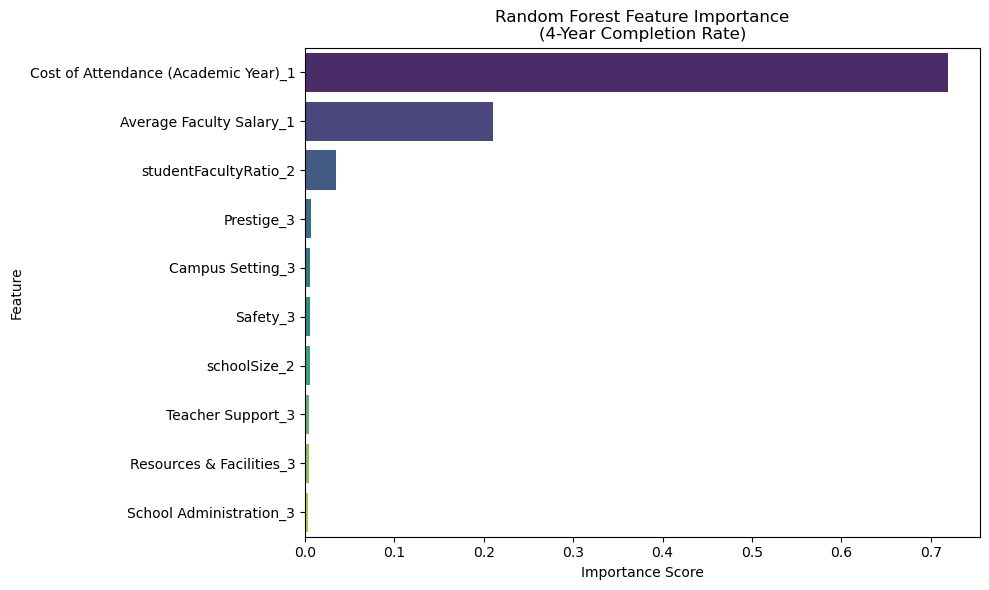

None


In [939]:
print(completion_rate_analysis(SCHOOL_ALL))

In [933]:
def base_salary_analysis(filename):

    df = pd.read_csv(filename)
    
    features = [
        'schoolSize_2', 
        'Average Faculty Salary_1', 
        '4-Year Completion Rate_1', 
        'Cost of Attendance (Academic Year)_1', 
        'Median Earnings (8 Years After Entry)_1',  
        'rank_2',  
        'studentFacultyRatio_2',  
        'Prestige_3', 
        'Resources & Facilities_3', 
        'Safety_3', 'Teacher Support_3', 
        'School Administration_3', 
        'Campus Setting_3']
    
    schools_filtered = df[features]
    
    # account for categorical data of school size
    size_map = {'small': 1, 'medium': 2, 'large': 3}
    df['schoolSize_2'] = df['schoolSize_2'].map(size_map)
    
    # make random forest to find which values are most important in predicting base salary

    target = 'medianBaseSalary_2'
    df_model = df.dropna(subset=[target])

    X = df_model[features]
    y = df_model[target]
    
    rf = RandomForestRegressor(random_state=42)
    rf.fit(X, y)
    
    # show plot
    plt.figure(figsize=(10, 6))
    sns.barplot(x=importances.values, y=importances.index, hue=importances.index, palette='viridis', legend=False)
    plt.title('Random Forest Feature Importance\n(Median Base Salary)')
    plt.xlabel('Importance Score')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show()



Feature Importances for Predicting Baseline Salary:

Median Earnings (8 Years After Entry)_1    0.672323
rank_2                                     0.088131
Cost of Attendance (Academic Year)_1       0.053560
Average Faculty Salary_1                   0.040995
4-Year Completion Rate_1                   0.030015
studentFacultyRatio_2                      0.020916
Prestige_3                                 0.018515
Safety_3                                   0.017916
Campus Setting_3                           0.016098
School Administration_3                    0.015010
Teacher Support_3                          0.010925
Resources & Facilities_3                   0.010880
schoolSize_2                               0.004714
dtype: float64


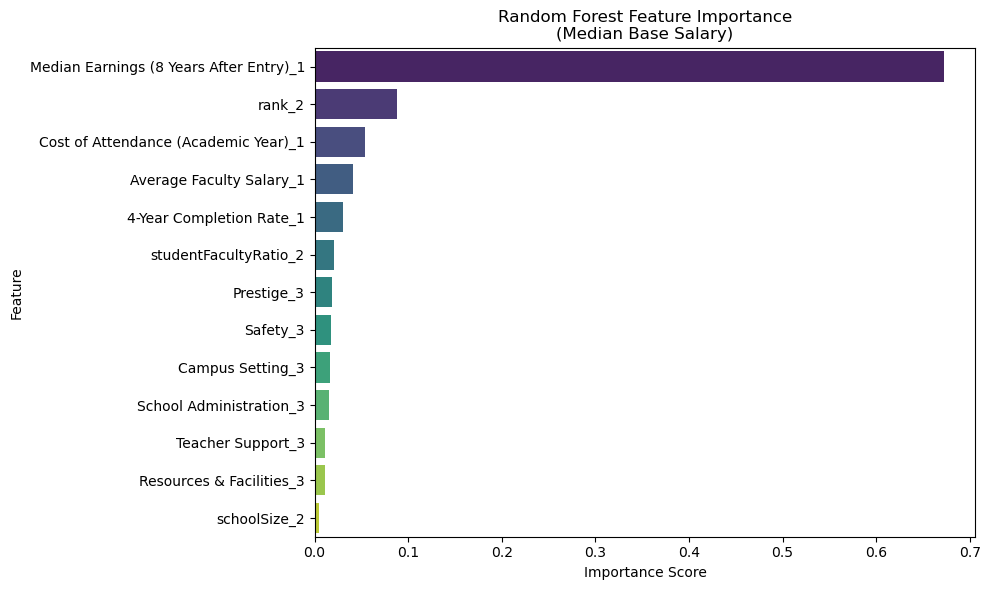

None


In [935]:
print(base_salary_analysis(SCHOOL_ALL))

In [941]:
def get_success_corr(filename):

    df = pd.read_csv(filename)

    columns = [
        'schoolSize_2', 
        'Average Faculty Salary_1', 
        '4-Year Completion Rate_1', 
        'Cost of Attendance (Academic Year)_1', 
        'Median Earnings (8 Years After Entry)_1',  
        'rank_2',  
        'studentFacultyRatio_2',  
        'Prestige_3', 
        'Resources & Facilities_3', 
        'Safety_3', 
        'Teacher Support_3', 
        'School Administration_3', 
        'Campus Setting_3',
        'medianBaseSalary_2'
    ]


    df = df[columns].copy()

    size_map = {'small': 1, 'medium': 2, 'large': 3}
    df['schoolSize_2'] = df['schoolSize_2'].map(size_map)

    # normalize vals, remove na
    for col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    clean_df = df.dropna()

    # correlation matrix and heatmap
    correlation_matrix = clean_df.corr()

    plt.figure(figsize=(18, 14))
    sns.heatmap(correlation_matrix, cmap='coolwarm', annot=True, fmt=".2f", square=True)
    plt.title('Correlation Heatmap of Student Success Factors')
    plt.tight_layout()
    plt.show()

    return correlation_matrix.round(4)

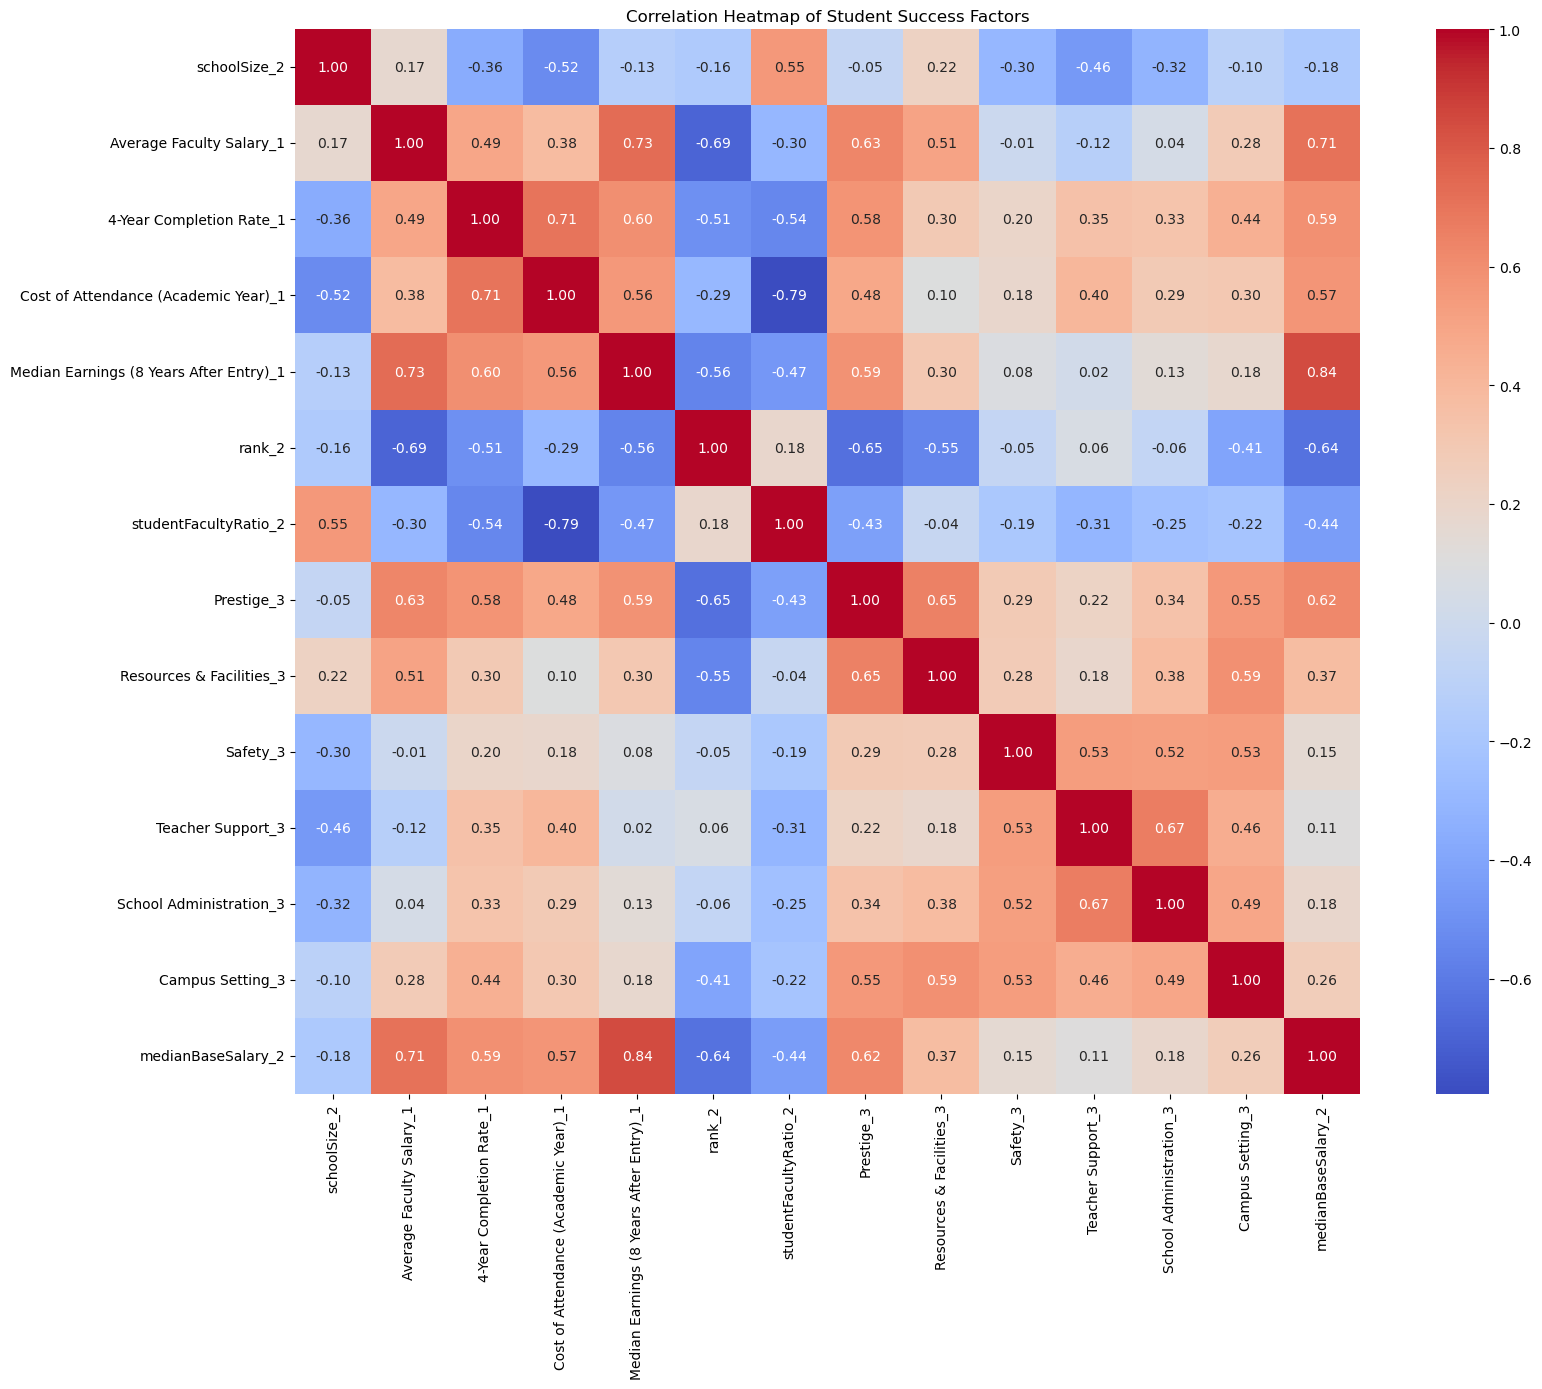

                                         schoolSize_2  \
schoolSize_2                                   1.0000   
Average Faculty Salary_1                       0.1675   
4-Year Completion Rate_1                      -0.3616   
Cost of Attendance (Academic Year)_1          -0.5231   
Median Earnings (8 Years After Entry)_1       -0.1346   
rank_2                                        -0.1635   
studentFacultyRatio_2                          0.5532   
Prestige_3                                    -0.0537   
Resources & Facilities_3                       0.2226   
Safety_3                                      -0.3029   
Teacher Support_3                             -0.4599   
School Administration_3                       -0.3231   
Campus Setting_3                              -0.1043   
medianBaseSalary_2                            -0.1818   

                                         Average Faculty Salary_1  \
schoolSize_2                                               0.1675   
Averag

In [943]:
print(get_success_corr(SCHOOL_ALL))

<h2>MyPlan Analysis</h2>

In [945]:
def analyze_myplan_rankings(filename):
    rankings_df = pd.read_csv(filename)
    
    # use numeric columns for correlation analysis
    numeric_columns = rankings_df.select_dtypes(include=['float64', 'int64']).columns
    numeric_df = rankings_df[numeric_columns]
    
    # correlation matrix and heatmap
    correlation_matrix = numeric_df.corr()
    
    plt.figure(figsize=(10, 6))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
    plt.title('Correlation Matrix')
    plt.show()

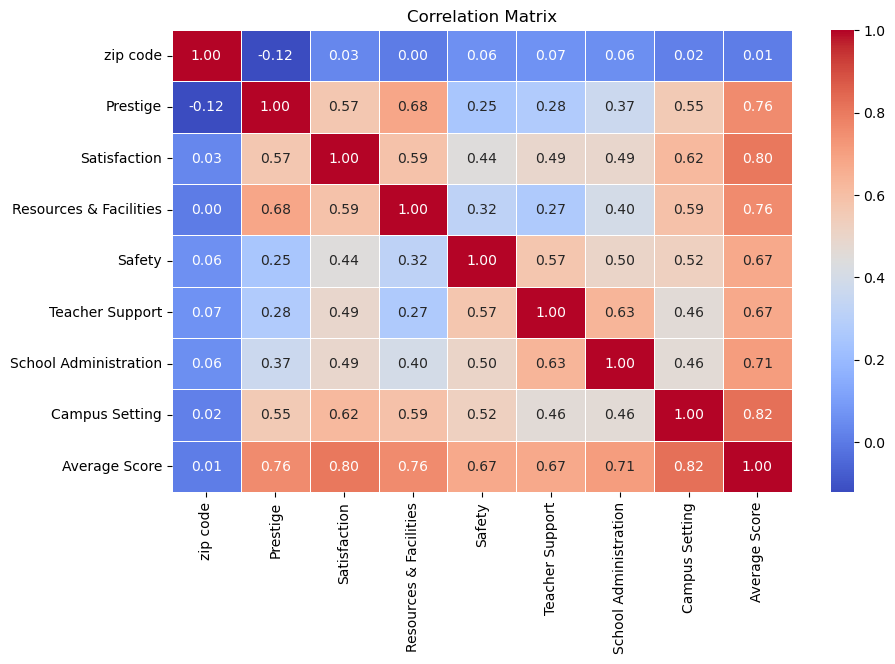

In [947]:
analyze_myplan_rankings(SCHOOL_RATINGS)

In [ ]:
# analysis
# interesting correlations to explore -- resources & facilities / prestige, teacher support / administration, satisfaction / campus setting
# high correlation between avg score and all variables - esp. campus setting and satisfaction. why??
# safety is not that impactful -- crime stat correlation builds on this!

<h2>Schools Complete</h2>

<h4>Admission Rate Analysis</h4>
What factors contribute to a higher admission rate?

In [840]:
def admission_rate_analysis(filename):
    schools_df = pd.read_csv(filename)
    
    columns_of_interest = [
        'Average SAT Score_1', 
        'Admission Rate_1', 
        '4-Year Completion Rate_1', 
        'Average Faculty Salary_1', 
        'Median Debt of Completers_1',
        'Resources & Facilities_3',
        'Prestige_3', 
        'Satisfaction_3',
        'Campus Setting_3'
    ]


    schools_filtered = schools_df[columns_of_interest] # only include relevant columns
    schools_filtered = schools_filtered.apply(pd.to_numeric, errors='coerce') # make sure all columns are numeric for analysis
    schools_filtered.dropna(inplace=True) # drop rows with non numeric data

    # correlation matrix
    correlation_matrix = schools_filtered.corr()
    print("Correlation Matrix")
    print(correlation_matrix)
    
    # visualize the correlation matrix using a heatmap
    plt.figure(figsize=(10, 7))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1)
    plt.title('Correlation Matrix Between Key Metrics')
    plt.show()

Correlation Matrix
                             Average SAT Score_1  Admission Rate_1  \
Average SAT Score_1                     1.000000         -0.827762   
Admission Rate_1                       -0.827762          1.000000   
4-Year Completion Rate_1                0.775384         -0.665702   
Average Faculty Salary_1                0.707570         -0.669764   
Median Debt of Completers_1            -0.312012          0.427326   
Resources & Facilities_3                0.430013         -0.452670   
Prestige_3                              0.737284         -0.666903   
Satisfaction_3                          0.376133         -0.377287   
Campus Setting_3                        0.406286         -0.402001   

                             4-Year Completion Rate_1  \
Average SAT Score_1                          0.775384   
Admission Rate_1                            -0.665702   
4-Year Completion Rate_1                     1.000000   
Average Faculty Salary_1                     0.50609

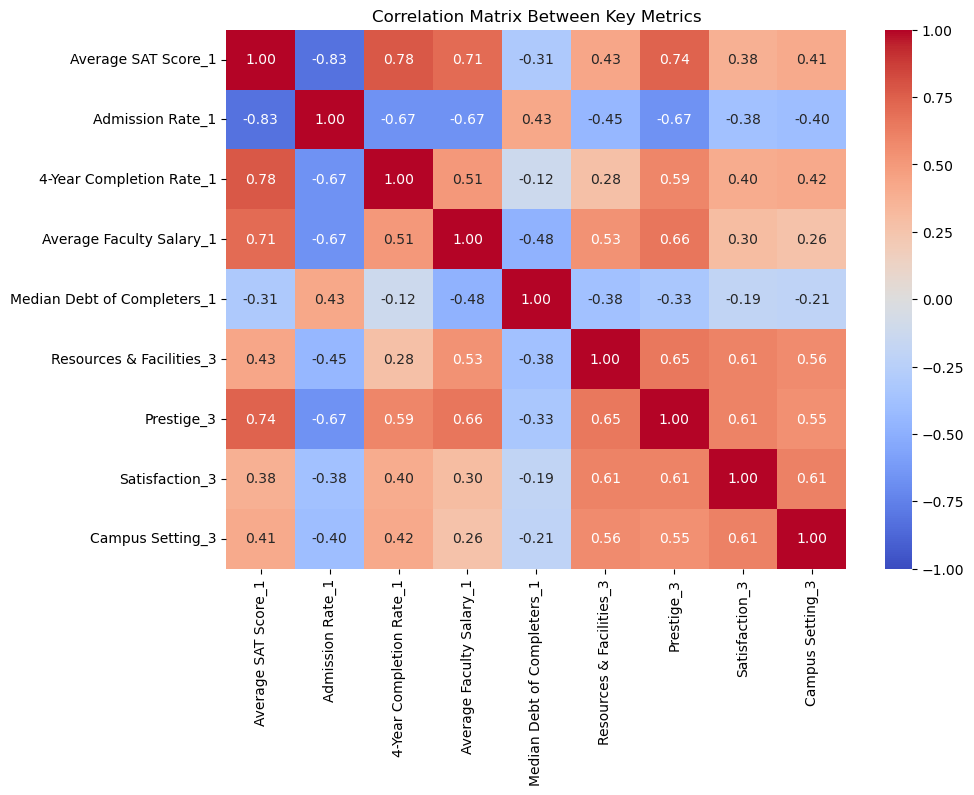

In [842]:
admission_rate_analysis(SCHOOL_COMPLETE)

In [ ]:
# analysis

# Selectivity and Resources: 
# More selective schools (higher SAT scores) - lower admission rates, higher faculty salaries, and lower student debt

# Completion Rates and Faculty Salaries
# higher faculty salaries - better graduation rates

# Debt Burden
# higher admission rates - more students graduating with debt - fewer resources, scholarships, or fin aid ??

In [836]:
#make scatter plot comparing SAT scores to admission rates
# negatively correlated - the lower the acceptance rate, the higer the SAT score
def compare_sat_admissions(filename):
    df = pd.read_csv(filename)  
    df = df[['Average SAT Score_1', 'Admission Rate_1']].dropna()
    
    # convert columns to numeric and drop missing data
    df['Average SAT Score_1'] = pd.to_numeric(df['Average SAT Score_1'], errors='coerce')
    df['Admission Rate_1'] = pd.to_numeric(df['Admission Rate_1'], errors='coerce')
    df.dropna(inplace=True)
    
    # make scatterplot with Regression Line
    sns.regplot(data=df, x='Average SAT Score_1', y='Admission Rate_1', scatter_kws={'alpha':0.6})
    plt.title('SAT Scores vs. Admission Rates with Regression Line')
    plt.xlabel('Average SAT Score')
    plt.ylabel('Admission Rate')
    plt.show()

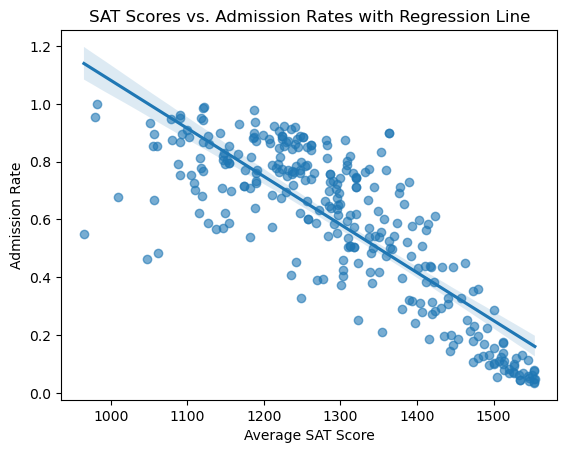

In [838]:
compare_sat_admissions(SCHOOL_COMPLETE)

<h4>Price Analysis</h4>
What factors contribute to a higher cost of attendance?

In [822]:
def get_full_corr_matrix(filename):
    schools_df = pd.read_csv(filename)
    
    # clean weird or missing values
    schools_df.replace(['--', 'N/A', 'NULL', '[NULL]', '', 'nan'], pd.NA, inplace=True)
    
    columns_of_interest = [
        'Zip Code_1', 'school', 'City_1', 'State_1', 'Locale_1', 'Average Faculty Salary_1', 
         'Average SAT Score_1', 'Admission Rate_1', '4-Year Completion Rate_1', 'Cost of Attendance (Academic Year)_1', 
         'Median Debt of Completers_1', 'Median Earnings (8 Years After Entry)_1', 'Mean Earnings (8 Years After Entry)_1', 
         'rank_2', 'state_2', 'grade_2', 'medianBaseSalary_2', 'studentPopulation_2', 'campusSetting_2', 'schoolSize_2', 'description_2', 
         'uri_2', 'institutionType_2', 'carnegieClassification_2', 'studentFacultyRatio_2', 'totalGrantAid_2', 'percentOfStudentsFinAid_2', 
         'percentOfStudentsGrant_2', 'Prestige_3', 'Satisfaction_3', 'Resources & Facilities_3', 'Safety_3', 'Teacher Support_3', 
         'School Administration_3', 'Campus Setting_3', 'Average Score_3', 'Average Net Price_1'
    ]


    schools_filtered = schools_df[columns_of_interest].copy()
    
    for col in schools_filtered.columns: # strip symbols and convert to numeric
        schools_filtered[col] = (
            schools_filtered[col]
            .astype(str)
            .str.replace(r'[\$,%,,]', '', regex=True)
            .replace('nan', pd.NA)
        )
        schools_filtered[col] = pd.to_numeric(schools_filtered[col], errors='coerce')
    
    schools_filtered = schools_filtered.loc[:, schools_filtered.isnull().mean() < 0.3] # drop columns with high amount of missing values >30%
    schools_filtered.dropna(inplace=True)
    
    # get correlation
    correlation_matrix = schools_filtered.corr()
    
    # get heat map
    plt.figure(figsize=(14, 12))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1)
    plt.title('Correlation Matrix Between School Metrics')
    plt.show()

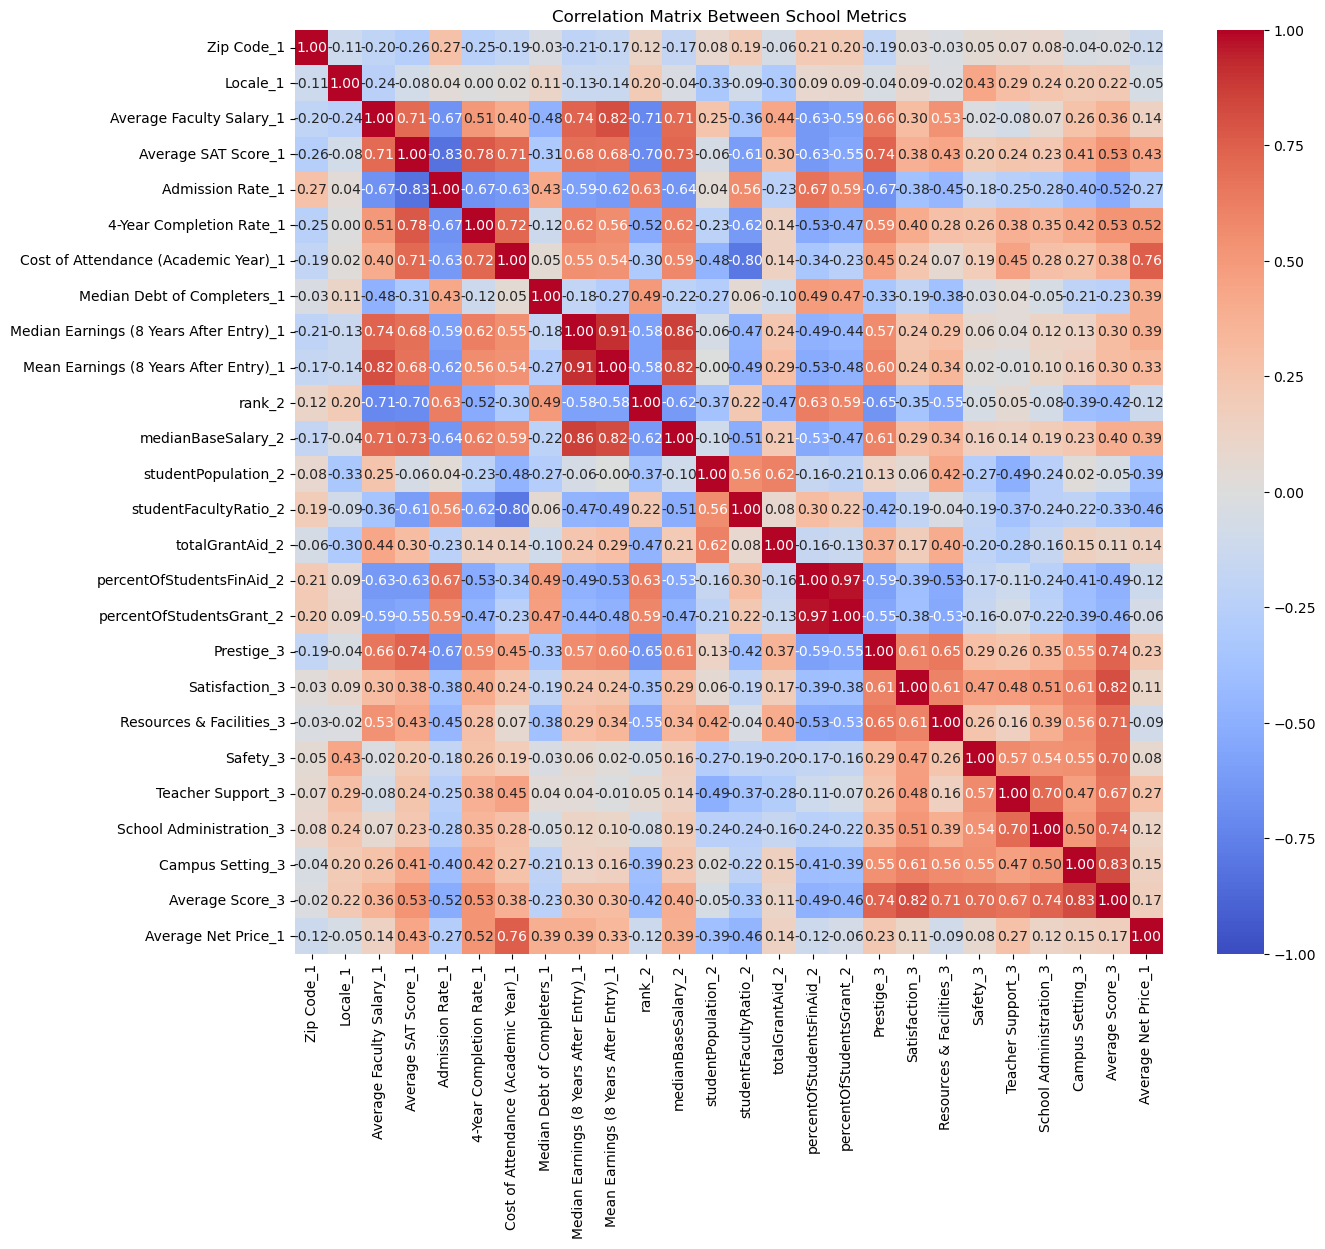

In [824]:
get_full_corr_matrix(SCHOOL_COMPLETE)

<h3>Zip Code Analysis</h3>
Where should my kid go to college?

In [954]:
def rankings_by_zip(filename):
    df = pd.read_csv(filename)

    # group by Zip Code and calculate mean
    zip_ranking = df.groupby('zip code')[['Prestige', 'Satisfaction', 'Resources & Facilities', 'Safety', 
                                          'Teacher Support', 'School Administration', 'Campus Setting', 'Average Score']].mean().reset_index()

    # used to hold outliers
    high_outliers = pd.DataFrame(columns=['zip code'])
    low_outliers = pd.DataFrame(columns=['zip code'])

    # id outliers using IQR method (1.5*IQR rule)
    for column in ['Prestige', 'Satisfaction', 'Resources & Facilities', 'Safety', 
                   'Teacher Support', 'School Administration', 'Campus Setting', 'Average Score']:
        Q1 = zip_ranking[column].quantile(0.25)
        Q3 = zip_ranking[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        high = zip_ranking[zip_ranking[column] > upper_bound][['zip code']]
        low = zip_ranking[zip_ranking[column] < lower_bound][['zip code']]

        high_outliers = pd.concat([high_outliers, high])
        low_outliers = pd.concat([low_outliers, low])

    # drop duplicate outlier zip codes to plot data and normalize values (5 digit codes)
    high_outliers = high_outliers.drop_duplicates()
    low_outliers = low_outliers.drop_duplicates()

    high_outliers['zip code'] = high_outliers['zip code'].astype(str).str.zfill(5)
    low_outliers['zip code'] = low_outliers['zip code'].astype(str).str.zfill(5)

    # show boxplot of outlier scores
    plt.figure(figsize=(15, 6))
    sns.boxplot(data=zip_ranking.drop(columns=['zip code']))
    plt.title('Distribution of School Rankings by Zip Code')
    plt.ylabel('Score')
    plt.show()

    # load shapefile and exclude territories [schools outside of continental US are note included in our analysis]
    zcta_shapefile = "geo_files/tl_2024_us_zcta520.shp"
    zcta_gdf = gpd.read_file(zcta_shapefile)

    zcta_gdf = zcta_gdf[~zcta_gdf['ZCTA5CE20'].str.startswith(('006', '007', '008', '009', '96799', '969'))]
    zcta_gdf['ZCTA5CE20'] = zcta_gdf['ZCTA5CE20'].astype(str).str.zfill(5)

    # filter outliers for mapping
    high_gdf = zcta_gdf[zcta_gdf['ZCTA5CE20'].isin(high_outliers['zip code'])]
    low_gdf = zcta_gdf[zcta_gdf['ZCTA5CE20'].isin(low_outliers['zip code'])]

    # plot base map
    ax = zcta_gdf.plot(figsize=(20, 15), edgecolor='gray', color='lightgray')

    # overlay outliers
    high_gdf.plot(ax=ax, color='red', edgecolor='black', linewidth=2.5, zorder=2)
    low_gdf.plot(ax=ax, color='blue', edgecolor='black', linewidth=2.5, zorder=2)

    # make legend
    red_patch = mpatches.Patch(color='red', label='High Outliers')
    blue_patch = mpatches.Patch(color='blue', label='Low Outliers')
    plt.legend(handles=[red_patch, blue_patch], fontsize='small', title_fontsize='medium')

    # display map
    plt.title("ZCTAs with Outlier Education Scores")
    plt.axis('off')
    plt.show()

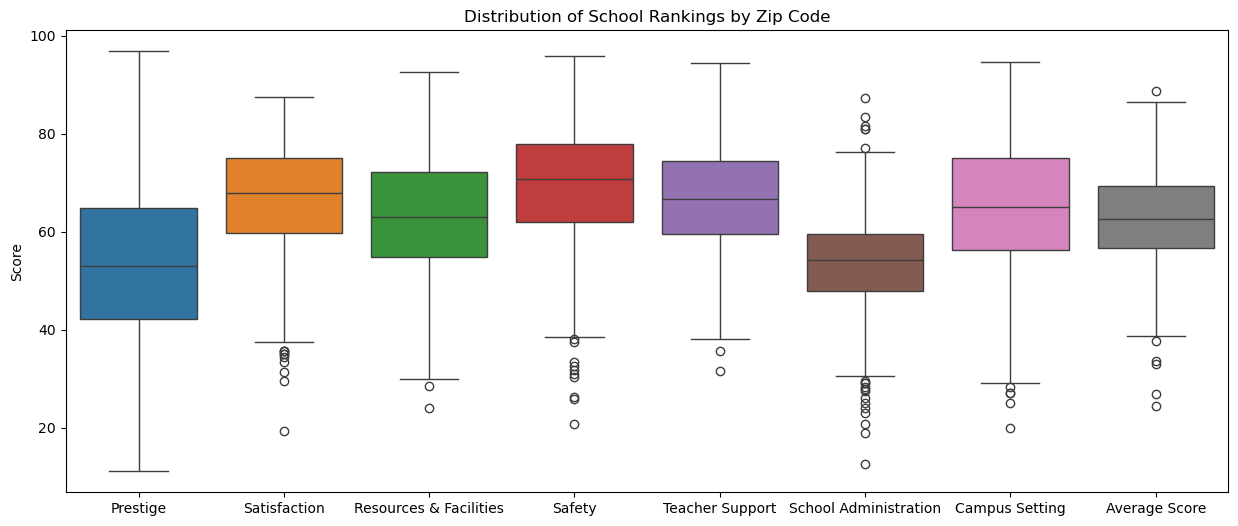

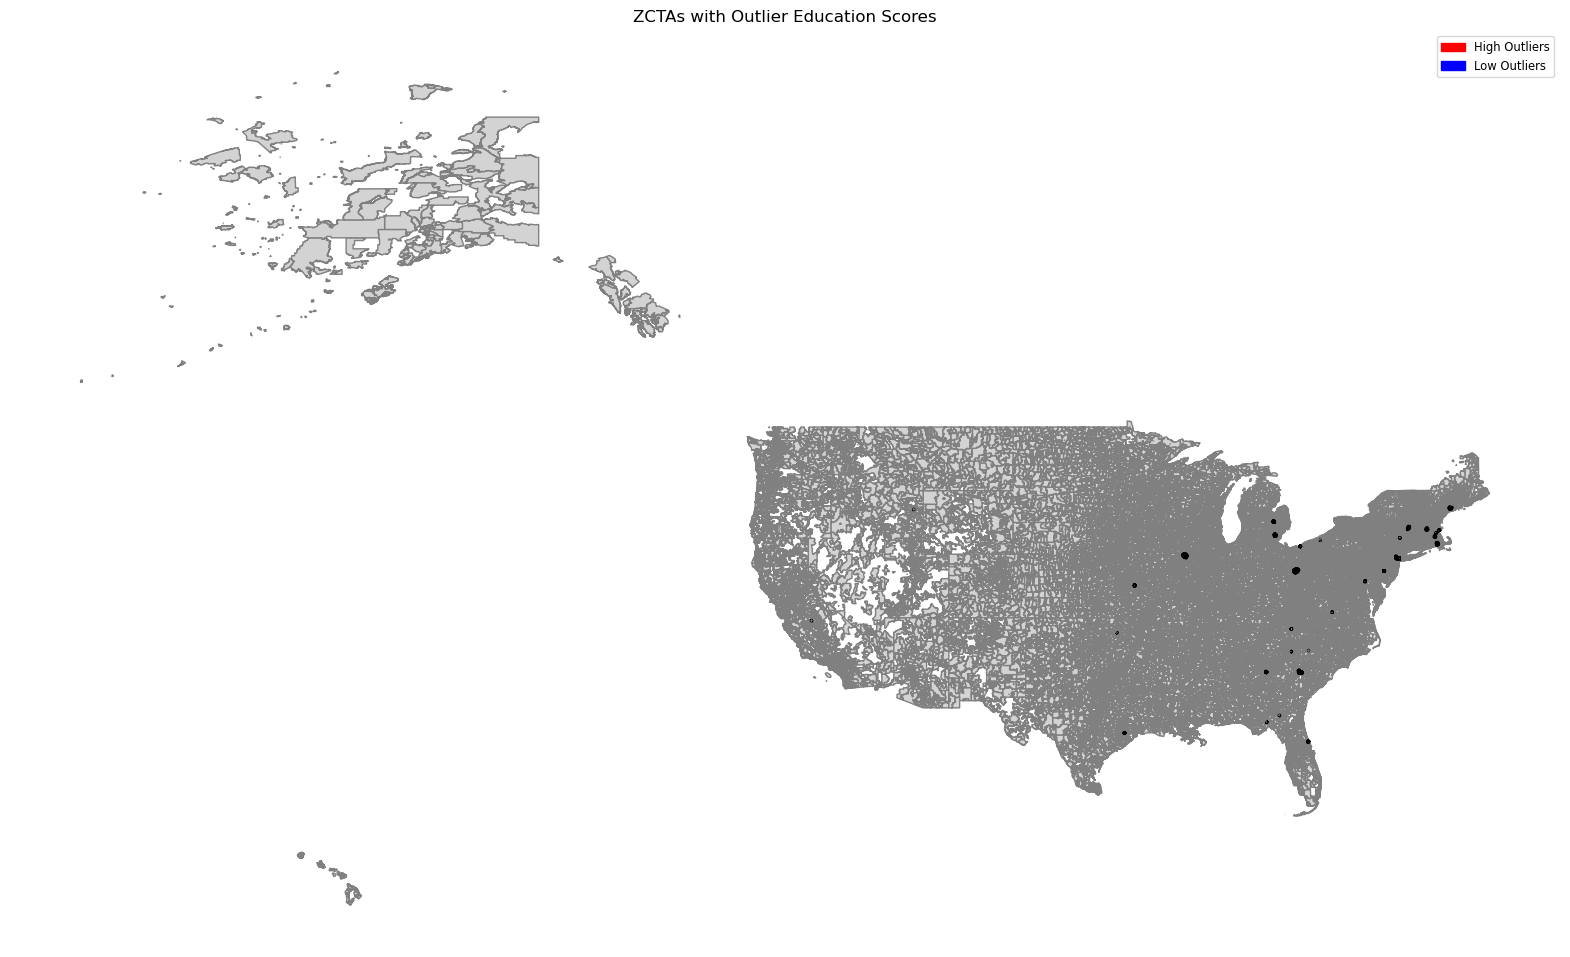

In [956]:
rankings_by_zip(SCHOOL_RATINGS)

In [ ]:
# analysis
# Zip Code 1420 (MA) - This zip shows up in almost every outlier list, and nearly all its values are low
# Zip Code 10065 (NY - Upper East Side) low in several metrics

<h3>Top Schools</h3>
Make a data file of schools that are in BOTH forbes and myplan high ranking scores for further analysis

In [290]:
# list of top myPlan Schools
def top_myplan_ratings(filename, n):
    df = pd.read_csv(filename)
    top_schools = df.sort_values(by='Average Score', ascending=False).head(n)
    return top_schools['School'].tolist()

In [324]:
top_myplan_schools = top_myplan_ratings(SCHOOL_RATINGS, 300)

In [302]:
# list of top Forbes Schools
def top_forbes_ratings(filename, n, column):
    df = pd.read_csv(filename)
    top_schools = df.sort_values(by=column, ascending=True).head(n)
    return top_schools['name'].tolist()

In [326]:
top_forbes_schools = top_forbes_ratings(SCHOOL_FORBES_ZIP, 300, 'rank')

In [314]:
def compare_forbes_myplan(forbes, myplan):
    return list(set(forbes) & set(myplan))


In [612]:
top_forbes_myplan = list(set(top_forbes_schools) & set(top_myplan_schools))

In [338]:
def check_school_names(top_schools, federal_filename):
    federal_df = pd.read_csv(federal_filename)
    federal_school_names = set(federal_df['School Name'].str.lower().str.strip())

    found = []
    missing = []

    for school in top_schools:
        if school.lower().strip() in federal_school_names:
            found.append(school)
        else:
            missing.append(school)

    return found

In [340]:
top_forbes_myplan_fed = check_school_names(top_forbes_myplan, SCHOOL_FED)

In [963]:
# merge top school data
def merge_top_schools(top_schools, forbes_file, myplan_file, federal_file, new_filename):
    forbes_df = pd.read_csv(forbes_file)
    myplan_df = pd.read_csv(myplan_file)
    federal_df = pd.read_csv(federal_file)

    # standardize and clean name columns
    forbes_df['school_name_clean'] = forbes_df['name'].str.lower().str.strip()
    myplan_df['school_name_clean'] = myplan_df['School'].str.lower().str.strip()
    federal_df['school_name_clean'] = federal_df['School Name'].str.lower().str.strip()

    top_clean = [s.lower().strip() for s in top_schools]

    # filter by top schools
    forbes_filtered = forbes_df[forbes_df['school_name_clean'].isin(top_clean)]
    myplan_filtered = myplan_df[myplan_df['school_name_clean'].isin(top_clean)]
    federal_filtered = federal_df[federal_df['school_name_clean'].isin(top_clean)]

    # merge on name and optionally on zip code if needed
    merged_df = forbes_filtered.merge(
        myplan_filtered,
        on='school_name_clean',
        how='outer',
        suffixes=('_forbes', '_myplan')
    ).merge(
        federal_filtered,
        on='school_name_clean',
        how='outer'
    )
    
    merged_df.to_csv(new_filename, index=False)
    return merged_df

In [961]:
merge_top_schools(top_forbes_myplan_fed, SCHOOL_FORBES_ZIP, SCHOOL_RATINGS, SCHOOL_FED, TOP_SCHOOLS)

['rank', 'name', 'zip code_forbes', 'state', 'grade', 'medianBaseSalary', 'studentPopulation', 'campusSetting', 'schoolSize', 'description', 'uri', 'institutionType', 'carnegieClassification', 'studentFacultyRatio', 'totalGrantAid', 'percentOfStudentsFinAid', 'percentOfStudentsGrant', 'school_name_clean', 'School', 'zip code_myplan', 'Prestige', 'Satisfaction', 'Resources & Facilities', 'Safety', 'Teacher Support', 'School Administration', 'Campus Setting', 'Average Score', 'Zip Code', 'School Name', 'City', 'State', 'Locale', 'Average Faculty Salary', 'Average SAT Score', 'Admission Rate', '4-Year Completion Rate', 'Average Net Price (Public)', 'Average Net Price (Private)', 'Cost of Attendance (Academic Year)', 'Median Debt of Completers', 'Median Earnings (8 Years After Entry)', 'Mean Earnings (8 Years After Entry)', 'Type']


,rank,name,zip code_forbes,state,grade,medianBaseSalary,studentPopulation,campusSetting,schoolSize,description,...,Average SAT Score,Admission Rate,4-Year Completion Rate,Average Net Price (Public),Average Net Price (Private),Cost of Attendance (Academic Year),Median Debt of Completers,Median Earnings (8 Years After Entry),Mean Earnings (8 Years After Entry),Type
0,271,adelphi university,11530,NY,C-,108000.0,8463,Suburban,medium,Adelphi University’s mission is to create a pe...,...,1224.0,0.7751,0.706501,NaN,28348.0,57444.0,25000.0,71399.0,56200.0,Private
1,141,american university,20016,DC,B-,129900.0,16934,Urban,large,"American University in Washington, D.C. is a p...",...,1392.0,0.4738,0.751327,NaN,41945.0,71549.0,22750.0,70443.0,56400.0,Private
2,24,amherst college,1002,MA,A+,139700.0,2041,Suburban,small,Amherst College is a private liberal arts coll...,...,1494.0,0.0982,0.842640,NaN,18246.0,83650.0,13740.0,86438.0,64800.0,Private
3,256,appalachian state university,28608,NC,NaN,99800.0,22221,Rural,large,"Located in Boone, NC, in the Blue Ridge Mounta...",...,1187.0,0.8864,0.685620,16487.0,NaN,22654.0,20231.0,48423.0,38100.0,Public
4,117,auburn university,36849,AL,NaN,123300.0,34568,Urban,large,Auburn University is a public research univers...,...,1318.0,0.5047,0.664000,23897.0,NaN,34402.0,21000.0,61406.0,50800.0,Public
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
184,287,whitman college,99362,WA,B+,135400.0,1607,Urban,small,A small private liberal arts college in Walla ...,...,1365.0,0.4999,0.874286,NaN,35506.0,75042.0,18437.0,60428.0,46400.0,Private
185,55,william&mary,23185,VA,NaN,134200.0,10550,Suburban,large,William & Mary is a public research university...,...,1458.0,0.3272,0.872340,22529.0,NaN,41118.0,18500.0,67721.0,60100.0,Public
186,17,williams college,1267,MA,A+,169200.0,2277,Rural,small,Williams College is a private liberal arts sch...,...,1527.0,0.0999,0.888889,NaN,14852.0,81164.0,12761.0,79082.0,60000.0,Private
187,166,worcester polytechnic institute,1609,MA,C+,161000.0,7761,Urban,medium,"Founded in 1865, Worcester Polytechnic Institu...",...,NaN,0.5850,0.827446,NaN,43273.0,75678.0,27000.0,100553.0,75100.0,Private


<h3>What makes Top Schools The Best?!</h3>
If I am running a university, how can i make my school the best?

In [636]:
def run_pca_on_schools_type(filename):
    df = pd.read_csv(filename)

    pca_features = [
        'Prestige', 'Satisfaction', 'Resources & Facilities', 'Safety',
        'Teacher Support', 'School Administration', 'Campus Setting',
        'Average Score', 'Admission Rate', '4-Year Completion Rate',
        'Average Net Price (Public)', 'Average Net Price (Private)',
        'Cost of Attendance (Academic Year)', 'Median Debt of Completers',
        'Median Earnings (8 Years After Entry)', 'Mean Earnings (8 Years After Entry)',
        'Average SAT Score', 'studentFacultyRatio', 'totalGrantAid'
    ]

    pca_features = [col for col in pca_features if col in df.columns]

    threshold = 0.7  # keep columns with at least 70% not missing data
    valid_features = [col for col in pca_features if df[col].notnull().mean() >= threshold]

    df_pca = df[valid_features].dropna()

    if df_pca.empty:
        print("PCA could not be run: No rows remain after filtering out missing values.")
        print("Available columns with missing data:")
        print(df[valid_features].isnull().sum())
        return None, None

    scaler = StandardScaler() #standardize values
    scaled_data = scaler.fit_transform(df_pca)

    pca = PCA(n_components=2)
    components = pca.fit_transform(scaled_data)

    # create a df with PCA results
    pca_df = pd.DataFrame(data=components, columns=['PC1', 'PC2'])

    # add school name and Type 
    if 'School' in df.columns:
        pca_df['School'] = df.loc[df_pca.index, 'School'].values
    if 'Type' in df.columns:
        pca_df['Type'] = df.loc[df_pca.index, 'Type'].values
    else:
        print("Warning: 'Type' column not found in dataset. Coloring by school instead.")
        pca_df['Type'] = df.loc[df_pca.index, 'School'].values  # fallback

    # plot PCA result, colored by 'Type'
    plt.figure(figsize=(12, 8))
    sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='Type', palette='Set2')
    plt.title('PCA of Top School Features by Type')
    plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% variance)')
    plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% variance)')
    plt.grid(True)
    plt.legend(title='School Type', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()
    
    # show component loadings with numerical values
    loadings = pd.DataFrame(pca.components_.T, index=valid_features, columns=['PC1', 'PC2'])
    print("\nTop Loadings for PC1 and PC2:")
    print(loadings.sort_values(by='PC1', ascending=False).head(5))
    print(loadings.sort_values(by='PC2', ascending=False).head(5))

    return pca_df, loadings

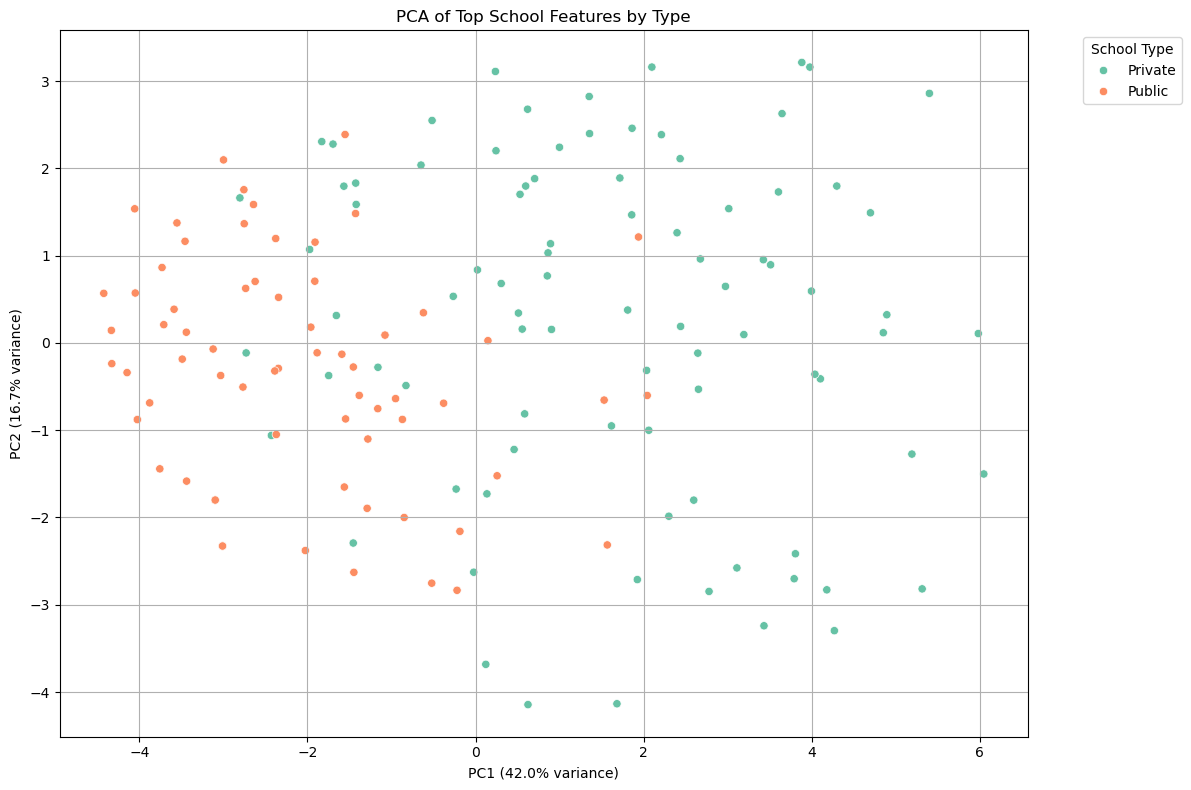


Top Loadings for PC1 and PC2:
                                         PC1       PC2
Average SAT Score                   0.339380 -0.119524
4-Year Completion Rate              0.305475  0.043377
Average Score                       0.302268  0.185291
Prestige                            0.298382 -0.202342
Cost of Attendance (Academic Year)  0.291297  0.061596
                            PC1       PC2
Teacher Support        0.149447  0.475593
Safety                 0.107108  0.374452
School Administration  0.170848  0.361391
Average Score          0.302268  0.185291
Campus Setting         0.139144  0.111396


(          PC1       PC2                         School     Type
 0   -2.730130 -0.113917             adelphi university  Private
 1   -1.161286 -0.278735            american university  Private
 2    3.512566  0.895639                amherst college  Private
 3   -1.552545  2.388726   appalachian state university   Public
 4   -1.077444  0.090109              auburn university   Public
 ..        ...       ...                            ...      ...
 151 -2.735836  0.625333  western washington university   Public
 152  0.597337  1.798245                whitman college  Private
 153  1.940426  1.214327                   william&mary   Public
 154  5.402801  2.860195               williams college  Private
 155  5.194577 -1.273382                yale university  Private
 
 [156 rows x 4 columns],
                                             PC1       PC2
 Prestige                               0.298382 -0.202342
 Satisfaction                           0.200325  0.033403
 Resources & Fac

In [968]:
run_pca_on_schools_type(TOP_SCHOOLS)

In [675]:
def run_pca_on_schools(filename):
    df = pd.read_csv(filename)

    pca_features = [
        'Prestige', 'Satisfaction', 'Resources & Facilities', 'Safety',
        'Teacher Support', 'School Administration', 'Campus Setting',
        'Average Score', 'Admission Rate', '4-Year Completion Rate',
        'Average Net Price (Public)', 'Average Net Price (Private)',
        'Cost of Attendance (Academic Year)', 'Median Debt of Completers',
        'Median Earnings (8 Years After Entry)', 'Mean Earnings (8 Years After Entry)',
        'Average SAT Score', 'studentFacultyRatio', 'totalGrantAid'
    ]

    pca_features = [col for col in pca_features if col in df.columns]

    # normalize vals and drop na
    threshold = 0.7  # keep columns with at least 70% non-null
    valid_features = [col for col in pca_features if df[col].notnull().mean() >= threshold]

    df_pca = df[valid_features].dropna()

    if df_pca.empty:
        print("PCA could not be run: No rows remain after filtering out missing values.")
        print("Available columns with missing data:")
        print(df[valid_features].isnull().sum())
        return None, None

    # standardize the data
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(df_pca)

    # run PCA and make it into a df
    pca = PCA(n_components=2)
    components = pca.fit_transform(scaled_data)
    pca_df = pd.DataFrame(data=components, columns=['PC1', 'PC2'])

    # add school name and Type
    if 'School' in df.columns:
        pca_df['School'] = df.loc[df_pca.index, 'School'].values
    if 'Type' in df.columns:
        pca_df['Type'] = df.loc[df_pca.index, 'Type'].values
    else:
        print("Warning: 'Type' column not found in dataset. Coloring by school instead.")
        pca_df['Type'] = df.loc[df_pca.index, 'School'].values  # fallback

    # create quadrant boundaries using the median
    pc1_median = pca_df['PC1'].median()
    pc2_median = pca_df['PC2'].median()
    
    # assign quadrant and apply function to schools based on pca
    def assign_quadrant(row):
        if row['PC1'] >= pc1_median and row['PC2'] >= pc2_median:
            return 'Top Right: Elite + Supportive'
        elif row['PC1'] < pc1_median and row['PC2'] >= pc2_median:
            return 'Top Left: Supportive but Less Selective'
        elif row['PC1'] < pc1_median and row['PC2'] < pc2_median:
            return 'Bottom Left: Less Selective & Less Supportive'
        else:
            return 'Bottom Right: Elite but Less Supportive'
    
    pca_df['Quadrant'] = pca_df.apply(assign_quadrant, axis=1)
    
    # plot each quadrant with different colors and add boundary lines, titles, legend
    plt.figure(figsize=(12, 8))
    sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='Quadrant', palette='Set2', s=100)
    plt.axvline(pc1_median, color='gray', linestyle='--')
    plt.axhline(pc2_median, color='gray', linestyle='--')
    
    plt.title('PCA of School Features: Quadrant Interpretation')
    plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% variance)\n← Less Elite | More Elite →')
    plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% variance)\n↓ Less Supportive | More Supportive ↓')
    plt.grid(True)
    plt.legend(title='Quadrant')
    plt.show()

    # print schools by quadrant
    quadrant_groups = pca_df.groupby('Quadrant')['School'].apply(list)

    for quadrant, schools in quadrant_groups.items():
        print(f"\n{quadrant} ({len(schools)} schools):")
        for school in schools:
            print(f" - {school}")

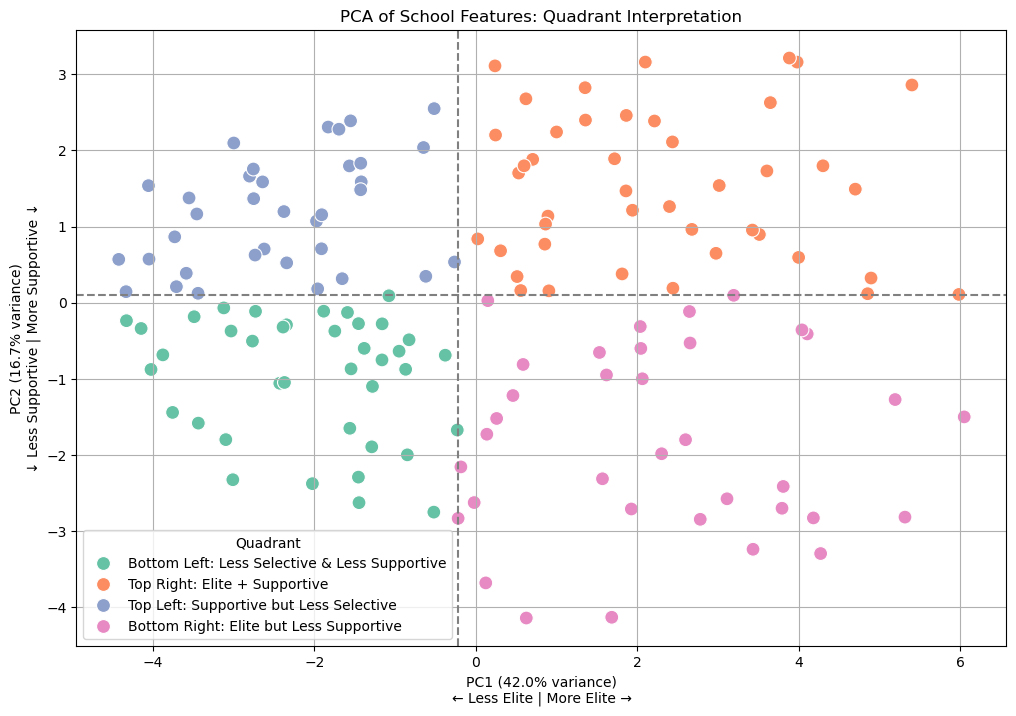


Bottom Left: Less Selective & Less Supportive (43 schools):
 - adelphi university
 - american university
 - auburn university
 - auburn university
 - baylor university
 - depaul university
 - florida international university
 - florida state university
 - indiana university bloomington
 - iowa state university
 - miami university
 - michigan state university
 - north carolina state university raleigh
 - ohio state university
 - pennsylvania state university main campus
 - purdue university
 - seattle university
 - syracuse university
 - texas a&m university college station
 - university of alabama
 - university of alabama
 - university of arizona
 - university of arizona
 - university of arkansas
 - university of arkansas
 - university of central florida
 - university of colorado boulder
 - university of delaware
 - university of georgia
 - university of illinois urbana champaign
 - university of iowa
 - university of kansas
 - university of maryland college park
 - university of miam

In [970]:
run_pca_on_schools(TOP_SCHOOLS)